In [159]:
import sys
sys.path.append("../code/")

In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

from loans import Loan
from market import simulate_stock_prices
from interest_rates import coupon_gap_per_user, simulate_antithetic_short_rates, construct_future_spot_rate_matrix

In [161]:
pd.set_option('display.max_columns', 50)

# Create Loan Portfolios

In [354]:
Q1_2018_Loans = pd.read_pickle("loans.pickle")#pd.read_csv('../data/LoanStats_securev1_2018Q1.csv', low_memory=False)
Q1_2018_Loans = Q1_2018_Loans[['id', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'issue_d']]
# percent_to_float = lambda x: float(x.strip('%')) / 100
Q1_2018_Loans['issue_d'] = pd.to_datetime(Q1_2018_Loans['issue_d'])
High_Yield_Portfolio = Q1_2018_Loans
# High_Yield_Portfolio = Q1_2018_Loans[Q1_2018_Loans.grade.isin({'E', 'F', 'G'})]
# High_Yield_Portfolio['int_rate'] = High_Yield_Portfolio.int_rate.apply(percent_to_float)
High_Yield_Portfolio['balance'] = High_Yield_Portfolio['funded_amnt']
High_Yield_Portfolio['apr'] = High_Yield_Portfolio['int_rate']
High_Yield_Portfolio['monthly_payment'] = High_Yield_Portfolio['installment']
High_Yield_Portfolio['origination_date'] = High_Yield_Portfolio['issue_d']
Clean_High_Yield_Portfolio = High_Yield_Portfolio[['id', 'balance', 'apr', 'monthly_payment', 'origination_date']]

In [360]:
High_Yield_Portfolio['apr'] = High_Yield_Portfolio['apr'] / 100
Clean_High_Yield_Portfolio['apr'] = Clean_High_Yield_Portfolio['apr'] / 100

In [355]:
High_Yield_Portfolio = High_Yield_Portfolio.drop_duplicates().reset_index(drop=True)
Clean_High_Yield_Portfolio = Clean_High_Yield_Portfolio.drop_duplicates().reset_index(drop=True)

In [315]:
loan_id_origination_list = High_Yield_Portfolio[['origination_date', 'id']].to_dict('records')
loan_id_origination_dict = {}
for item in loan_id_origination_list:
    loan_id_origination_dict[item['id']] = item['origination_date']

In [279]:
# print(kaggle_loans.columns.values)

In [296]:
# kaggle_loans = pd.read_pickle("loans.pickle")
# kaggle_loans = kaggle_loans[['id', 'balance', 'apr', 'monthly_payment', 'origination_date']]

In [338]:
default_probas = pd.read_pickle("pred_val.pickle")

In [339]:
default_probas.head()

,id,installment_num,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,sim_10,sim_11,sim_12,sim_13,sim_14,sim_15,sim_16,sim_17,sim_18,sim_19,sim_20,sim_21,sim_22,sim_23,...,sim_975,sim_976,sim_977,sim_978,sim_979,sim_980,sim_981,sim_982,sim_983,sim_984,sim_985,sim_986,sim_987,sim_988,sim_989,sim_990,sim_991,sim_992,sim_993,sim_994,sim_995,sim_996,sim_997,sim_998,sim_999
0,134665147,2,0.999151,0.998051,0.999632,0.996854,0.991729,0.999411,0.999366,0.99846,0.99824,0.999649,0.99884,0.999204,0.997809,0.999462,0.997901,0.999552,0.999655,0.997933,0.999593,0.998806,0.998698,0.997428,0.998178,...,0.9964,0.998935,0.998443,0.999643,0.997734,0.997935,0.999049,0.998881,0.99936,0.998433,0.997719,0.998419,0.999102,0.997062,0.998907,0.99881,0.991816,0.997193,0.998457,0.996981,0.998516,0.997,0.998765,0.996777,0.999164
1,134665147,4,0.998198,0.995867,0.999219,0.993338,0.982583,0.998748,0.998654,0.996734,0.996266,0.999255,0.997539,0.99831,0.995355,0.998858,0.99555,0.999049,0.999268,0.995617,0.999135,0.997465,0.997238,0.99455,0.996137,...,0.99238,0.99774,0.996697,0.999243,0.995196,0.995622,0.997981,0.997624,0.998641,0.996677,0.995164,0.996646,0.998094,0.993776,0.99768,0.997474,0.982765,0.994054,0.996727,0.993606,0.99685,0.993645,0.99738,0.993174,0.998225
2,134665147,5,0.997376,0.993986,0.998862,0.990318,0.97481,0.998176,0.998039,0.995246,0.994566,0.998915,0.996416,0.997539,0.993243,0.998336,0.993526,0.998614,0.998933,0.993623,0.998739,0.996309,0.995978,0.992075,0.994378,...,0.98893,0.996708,0.995192,0.998896,0.993012,0.993631,0.997059,0.99654,0.998021,0.995162,0.992966,0.995118,0.997224,0.990952,0.996622,0.996321,0.975072,0.991355,0.995235,0.990706,0.995415,0.990763,0.996185,0.99008,0.997414
3,134665147,8,0.991914,0.981599,0.996482,0.9706,0.925875,0.994371,0.993949,0.985415,0.983354,0.996645,0.988978,0.992414,0.979359,0.994863,0.98021,0.995717,0.996701,0.980503,0.996103,0.988652,0.987644,0.975847,0.982784,...,0.966481,0.989872,0.985251,0.996588,0.978664,0.980527,0.990944,0.989358,0.993893,0.985163,0.978525,0.985028,0.991449,0.97249,0.989608,0.98869,0.926606,0.973694,0.985384,0.971757,0.98593,0.971924,0.988274,0.969892,0.992032
4,134665147,9,0.988255,0.973399,0.99488,0.95771,0.895486,0.991814,0.991203,0.978879,0.975917,0.995117,0.984012,0.988979,0.970191,0.992529,0.971408,0.993769,0.995198,0.971829,0.994329,0.983542,0.982089,0.965174,0.975098,...,0.951873,0.985303,0.978643,0.995034,0.969197,0.971863,0.986852,0.984561,0.991122,0.978516,0.968998,0.978322,0.987583,0.960395,0.984922,0.983596,0.896483,0.962106,0.978835,0.959352,0.97962,0.95959,0.982997,0.956705,0.988427


In [340]:
default_probas.shape

(2869, 1001)

In [341]:
loan_ids = default_probas.id.unique()
default_probas[default_probas.id == 134665147]

,id,installment_num,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,sim_10,sim_11,sim_12,sim_13,sim_14,sim_15,sim_16,sim_17,sim_18,sim_19,sim_20,sim_21,sim_22,sim_23,...,sim_975,sim_976,sim_977,sim_978,sim_979,sim_980,sim_981,sim_982,sim_983,sim_984,sim_985,sim_986,sim_987,sim_988,sim_989,sim_990,sim_991,sim_992,sim_993,sim_994,sim_995,sim_996,sim_997,sim_998,sim_999
0,134665147,2,0.999151,0.998051,0.999632,0.996854,0.991729,0.999411,0.999366,0.99846,0.99824,0.999649,0.99884,0.999204,0.997809,0.999462,0.997901,0.999552,0.999655,0.997933,0.999593,0.998806,0.998698,0.997428,0.998178,...,0.9964,0.998935,0.998443,0.999643,0.997734,0.997935,0.999049,0.998881,0.99936,0.998433,0.997719,0.998419,0.999102,0.997062,0.998907,0.99881,0.991816,0.997193,0.998457,0.996981,0.998516,0.997,0.998765,0.996777,0.999164
1,134665147,4,0.998198,0.995867,0.999219,0.993338,0.982583,0.998748,0.998654,0.996734,0.996266,0.999255,0.997539,0.99831,0.995355,0.998858,0.99555,0.999049,0.999268,0.995617,0.999135,0.997465,0.997238,0.99455,0.996137,...,0.99238,0.99774,0.996697,0.999243,0.995196,0.995622,0.997981,0.997624,0.998641,0.996677,0.995164,0.996646,0.998094,0.993776,0.99768,0.997474,0.982765,0.994054,0.996727,0.993606,0.99685,0.993645,0.99738,0.993174,0.998225
2,134665147,5,0.997376,0.993986,0.998862,0.990318,0.97481,0.998176,0.998039,0.995246,0.994566,0.998915,0.996416,0.997539,0.993243,0.998336,0.993526,0.998614,0.998933,0.993623,0.998739,0.996309,0.995978,0.992075,0.994378,...,0.98893,0.996708,0.995192,0.998896,0.993012,0.993631,0.997059,0.99654,0.998021,0.995162,0.992966,0.995118,0.997224,0.990952,0.996622,0.996321,0.975072,0.991355,0.995235,0.990706,0.995415,0.990763,0.996185,0.99008,0.997414
3,134665147,8,0.991914,0.981599,0.996482,0.9706,0.925875,0.994371,0.993949,0.985415,0.983354,0.996645,0.988978,0.992414,0.979359,0.994863,0.98021,0.995717,0.996701,0.980503,0.996103,0.988652,0.987644,0.975847,0.982784,...,0.966481,0.989872,0.985251,0.996588,0.978664,0.980527,0.990944,0.989358,0.993893,0.985163,0.978525,0.985028,0.991449,0.97249,0.989608,0.98869,0.926606,0.973694,0.985384,0.971757,0.98593,0.971924,0.988274,0.969892,0.992032
4,134665147,9,0.988255,0.973399,0.99488,0.95771,0.895486,0.991814,0.991203,0.978879,0.975917,0.995117,0.984012,0.988979,0.970191,0.992529,0.971408,0.993769,0.995198,0.971829,0.994329,0.983542,0.982089,0.965174,0.975098,...,0.951873,0.985303,0.978643,0.995034,0.969197,0.971863,0.986852,0.984561,0.991122,0.978516,0.968998,0.978322,0.987583,0.960395,0.984922,0.983596,0.896483,0.962106,0.978835,0.959352,0.97962,0.95959,0.982997,0.956705,0.988427
5,134665147,10,0.98297,0.961687,0.992554,0.93952,0.854595,0.988111,0.987227,0.969504,0.965274,0.992898,0.976862,0.984014,0.957129,0.989146,0.958857,0.990942,0.993014,0.959454,0.991755,0.976186,0.974101,0.950027,0.964107,...,0.931353,0.978718,0.969167,0.992776,0.955719,0.959503,0.980947,0.97765,0.987109,0.968985,0.955436,0.968708,0.982001,0.943291,0.978169,0.976265,0.855919,0.9457,0.969441,0.941825,0.970565,0.94216,0.975404,0.938111,0.983217
6,134665147,11,0.975365,0.945109,0.989182,0.914206,0.801256,0.982762,0.981487,0.956155,0.950167,0.98968,0.966623,0.976865,0.938704,0.984254,0.94113,0.98685,0.989849,0.941969,0.988025,0.965658,0.962686,0.928778,0.948521,...,0.902974,0.969274,0.955676,0.989504,0.936729,0.942038,0.972465,0.967748,0.981318,0.955419,0.936333,0.955026,0.973976,0.919421,0.968489,0.96577,0.802954,0.922761,0.956065,0.917392,0.957659,0.917855,0.964542,0.912263,0.97572


In [342]:
default_dict = {}
for id_, default_df in default_probas.groupby('id'):
    default_dict[id_] = default_df
    del default_dict[id_]['id']

In [337]:
# default_dict[134665147].columns = list(range(1000))
# default_dict[134665147]

In [343]:
installment_indexes = set(range(1,54))

In [402]:
final_defaults = {}
for id_, ddf in default_dict.items():
    existing_indexes = set(ddf.installment_num.values)
    missing_indexes = installment_indexes - existing_indexes
    ddf = ddf.merge(pd.DataFrame(installment_indexes, columns=['all_installment_num']), how='outer', left_on='installment_num', right_on='all_installment_num')
    ddf = ddf.sort_values('all_installment_num')
    ddf = ddf.fillna(method='bfill')
    ddf = ddf.fillna(method='ffill')
    origination_date = loan_id_origination_dict[id_]
    cashflow_dates = [origination_date + relativedelta(months=timestep) for timestep in range(1,54)]
    ddf = ddf.set_index(pd.to_datetime(cashflow_dates))
    del ddf['installment_num']
    del ddf['all_installment_num']
    ddf.columns = list(range(999))
    final_defaults[id_] = (1-ddf) / 100


In [361]:
Clean_High_Yield_Portfolio.head()

,id,balance,apr,monthly_payment,origination_date
0,134665147,30400.0,0.1403,707.83,2018-06-01
1,130823861,12000.0,0.0607,365.45,2018-03-01
2,139351926,28025.0,0.1614,987.22,2018-09-01
3,132863109,10000.0,0.1407,342.12,2018-05-01
4,138770475,10000.0,0.1356,339.65,2018-08-01


In [362]:
High_Yield_Portfolio.head()

,id,funded_amnt,term,int_rate,installment,grade,sub_grade,issue_d,balance,apr,monthly_payment,origination_date
0,134665147,30400.0,60,0.1403,707.83,C,C2,2018-06-01,30400.0,0.1403,707.83,2018-06-01
1,130823861,12000.0,36,0.0607,365.45,A,A2,2018-03-01,12000.0,0.0607,365.45,2018-03-01
2,139351926,28025.0,36,0.1614,987.22,C,C4,2018-09-01,28025.0,0.1614,987.22,2018-09-01
3,132863109,10000.0,36,0.1407,342.12,C,C3,2018-05-01,10000.0,0.1407,342.12,2018-05-01
4,138770475,10000.0,36,0.1356,339.65,C,C1,2018-08-01,10000.0,0.1356,339.65,2018-08-01


In [358]:
# loan_portfolio = kaggle_loans[kaggle_loans.id.isin(loan_ids)]
# loan_portfolio = loan_portfolio['id', 'balance', 'apr', 'monthly_payment', 'origination_date']
loan_portfolio

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,...,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term


In [163]:
# Clean_High_Yield_Portfolio = Clean_High_Yield_Portfolio.sample(10)

In [221]:
# Clean_High_Yield_Portfolio.shape

In [220]:
# Clean_High_Yield_Portfolio.head()

In [222]:
# Q1_2018_Loans.grade.value_counts()

In [167]:
High_Yield_Portfolio.shape

(4489, 12)

In [168]:
High_Yield_Portfolio.int_rate.mean()

0.2577864335041212

In [363]:
portfolio_loan_ids = Clean_High_Yield_Portfolio.id.values
del Clean_High_Yield_Portfolio['id']

In [364]:
portfolio = [Loan(**loan_params) for loan_params in Clean_High_Yield_Portfolio.to_dict('records')]

# Simulate Market

In [199]:
num_simulations = 1000  # individual paths
num_periods = 42  # months
num_loans = High_Yield_Portfolio.shape[0]

## S&P 500

In [200]:
# S&P Parameters
S = 2789.800  # 1.1.2018 Price
dT = 1/12
sigma = 0.157
r = 0.08
y = 0.0198
s_and_p_start_date = datetime(2018, 1, 1)
num_market_periods = 54
market_dates = [s_and_p_start_date + relativedelta(months=timestep) for timestep in range(num_market_periods)]

In [201]:
market_simulation = simulate_stock_prices(num_simulations, num_market_periods, S, dT, sigma, r, y)
# TODO: add dates to market simulation

In [202]:
print(market_simulation.shape)

(1000, 54)


In [203]:
market_simulation = pd.DataFrame(market_simulation.T, index=market_dates)

In [204]:
df = pd.DataFrame(market_simulation.T)

In [198]:
np.split(df.index, 25)

[Int64Index([0, 1, 2, 3], dtype='int64'),
 Int64Index([4, 5, 6, 7], dtype='int64'),
 Int64Index([8, 9, 10, 11], dtype='int64'),
 Int64Index([12, 13, 14, 15], dtype='int64'),
 Int64Index([16, 17, 18, 19], dtype='int64'),
 Int64Index([20, 21, 22, 23], dtype='int64'),
 Int64Index([24, 25, 26, 27], dtype='int64'),
 Int64Index([28, 29, 30, 31], dtype='int64'),
 Int64Index([32, 33, 34, 35], dtype='int64'),
 Int64Index([36, 37, 38, 39], dtype='int64'),
 Int64Index([40, 41, 42, 43], dtype='int64'),
 Int64Index([44, 45, 46, 47], dtype='int64'),
 Int64Index([48, 49, 50, 51], dtype='int64'),
 Int64Index([52, 53, 54, 55], dtype='int64'),
 Int64Index([56, 57, 58, 59], dtype='int64'),
 Int64Index([60, 61, 62, 63], dtype='int64'),
 Int64Index([64, 65, 66, 67], dtype='int64'),
 Int64Index([68, 69, 70, 71], dtype='int64'),
 Int64Index([72, 73, 74, 75], dtype='int64'),
 Int64Index([76, 77, 78, 79], dtype='int64'),
 Int64Index([80, 81, 82, 83], dtype='int64'),
 Int64Index([84, 85, 86, 87], dtype='int64')

In [205]:
market_simulation.to_pickle('snp500_simulation.p')

## Interest Rates

In [206]:
# Interest Rate Parameters
num_interest_periods = 54
coupon_gap_period = 3  # years
short_rate_on_august_30_2004 = 1.45 / 100
theta = 0.004624
kappa = 0.114676
sigma = 0.01456
short_rates_start_date = datetime(2018, 1, 1)
short_rates_dates = [short_rates_start_date + relativedelta(months=timestep) for timestep in range(num_interest_periods + 1)]

origination_dates = pd.to_datetime(High_Yield_Portfolio.origination_date.values)
loan_rates = np.tile(High_Yield_Portfolio.int_rate.values, (num_periods, 1)).T

In [207]:
# calculate discount factors
short_rates, short_rates_anti = simulate_antithetic_short_rates(num_simulations, num_interest_periods, theta, kappa, sigma, short_rate_on_august_30_2004)
discount_factors = np.cumprod(np.exp(-short_rates / 12), axis=1)
discount_factors_anti = np.cumprod(np.exp(-short_rates_anti / 12), axis=1)

# calculate 10 year rates
future_spot_rates = construct_future_spot_rate_matrix(coupon_gap_period, short_rates, theta, kappa, sigma, num_interest_periods+1)
future_spot_rates_anti = construct_future_spot_rate_matrix(coupon_gap_period, short_rates_anti, theta, kappa, sigma, num_interest_periods+1)

In [208]:
# calculate coupon gaps per loan per simulation
# coupon_gaps = coupon_gap_per_user(loan_rates, future_spot_rates, origination_dates)

In [209]:
future_rates_df = pd.DataFrame(future_spot_rates.T, index=short_rates_dates)
future_rates_df.to_pickle('future_spot_rates.p')

In [210]:
future_rates_df.shape

(55, 1000)

## Savings Rate

# Calculate PDs

In [215]:
pd_dataframes = pd.read_pickle("pred_val.pickle")

In [217]:
pd_dataframes.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.999359,0.999151,0.998051,0.999632,0.996854,0.991729,0.999411,0.999366,0.998460,0.998240,0.999649,0.998840,0.999204,0.997809,0.999462,0.997901,0.999552,0.999655,0.997933,0.999593,0.998806,0.998698,0.997428,0.998178,0.997731,...,0.996400,0.998935,0.998443,0.999643,0.997734,0.997935,0.999049,0.998881,0.999360,0.998433,0.997719,0.998419,0.999102,0.997062,0.998907,0.998810,0.991816,0.997193,0.998457,0.996981,0.998516,0.997000,0.998765,0.996777,0.999164
1,0.998639,0.998198,0.995867,0.999219,0.993338,0.982583,0.998748,0.998654,0.996734,0.996266,0.999255,0.997539,0.998310,0.995355,0.998858,0.995550,0.999049,0.999268,0.995617,0.999135,0.997465,0.997238,0.994550,0.996137,0.995190,...,0.992380,0.997740,0.996697,0.999243,0.995196,0.995622,0.997981,0.997624,0.998641,0.996677,0.995164,0.996646,0.998094,0.993776,0.997680,0.997474,0.982765,0.994054,0.996727,0.993606,0.996850,0.993645,0.997380,0.993174,0.998225
2,0.998017,0.997376,0.993986,0.998862,0.990318,0.974810,0.998176,0.998039,0.995246,0.994566,0.998915,0.996416,0.997539,0.993243,0.998336,0.993526,0.998614,0.998933,0.993623,0.998739,0.996309,0.995978,0.992075,0.994378,0.993003,...,0.988930,0.996708,0.995192,0.998896,0.993012,0.993631,0.997059,0.996540,0.998021,0.995162,0.992966,0.995118,0.997224,0.990952,0.996622,0.996321,0.975072,0.991355,0.995235,0.990706,0.995415,0.990763,0.996185,0.990080,0.997414
3,0.993883,0.991914,0.981599,0.996482,0.970600,0.925875,0.994371,0.993949,0.985415,0.983354,0.996645,0.988978,0.992414,0.979359,0.994863,0.980210,0.995717,0.996701,0.980503,0.996103,0.988652,0.987644,0.975847,0.982784,0.978635,...,0.966481,0.989872,0.985251,0.996588,0.978664,0.980527,0.990944,0.989358,0.993893,0.985163,0.978525,0.985028,0.991449,0.972490,0.989608,0.988690,0.926606,0.973694,0.985384,0.971757,0.985930,0.971924,0.988274,0.969892,0.992032
4,0.991107,0.988255,0.973399,0.994880,0.957710,0.895486,0.991814,0.991203,0.978879,0.975917,0.995117,0.984012,0.988979,0.970191,0.992529,0.971408,0.993769,0.995198,0.971829,0.994329,0.983542,0.982089,0.965174,0.975098,0.969155,...,0.951873,0.985303,0.978643,0.995034,0.969197,0.971863,0.986852,0.984561,0.991122,0.978516,0.968998,0.978322,0.987583,0.960395,0.984922,0.983596,0.896483,0.962106,0.978835,0.959352,0.979620,0.959590,0.982997,0.956705,0.988427


In [218]:
pd_dataframes.shape

(2869, 1000)

In [112]:
# def calc_psa_cpr(speed, period):
#     return (speed / 100) * 0.06 * min(1, float(period) / 30)

# def calc_psa_smm(speed, period):
#     cpr = calc_psa_cpr(speed, period)
#     return 1 - (1 - cpr) ** (1.0 / 12)

# def fake_pd_data(origination_dates, num_periods):
#     pd_dataframes = []
#     for start_date in origination_dates:
#         cashflow_dates = [start_date + relativedelta(months=timestep + 1) for timestep in range(num_periods)]
#         mortalities = [calc_psa_smm(0, timestep + 1) for timestep in range(num_periods)]
#         pd_dataframes.append(pd.DataFrame(np.repeat(mortalities, 1000).reshape(-1, 1000) * np.random.uniform(0.5, 1.5, (num_periods, 1000)), index=cashflow_dates))
#     return pd_dataframes

In [113]:
# fake default probabilities
# pd_dataframes = fake_pd_data(origination_dates, num_periods)

In [114]:
pd_dataframes[0].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
2018-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [211]:
short_rates_df.to_pickle('short_rates.p')

# Simulate Future Loan States and Realized Cashflows

In [118]:
short_rates_df = pd.DataFrame(short_rates.T, index=short_rates_dates)

In [367]:
# del short_rates_df[999]
# short_rates_df

In [119]:
var_cutoff_date = datetime(2019, 4, 1)
todays_date = datetime(2018, 1, 1)

In [403]:
def multiprocess_loan_pricing(loan_idx, loan_porfolio=portfolio, loan_ids=portfolio_loan_ids, cutoff=var_cutoff_date ,rates=short_rates_df, default_dfs=final_defaults):
    l_id = loan_ids[loan_idx]
    ddf = default_dfs[l_id]
    return loan_porfolio[loan_idx].calc_value_distribution(cutoff, rates, ddf)

In [478]:
def multiprocess_loan_pricing_todays_value(loan_idx, loan_porfolio=portfolio, loan_ids=portfolio_loan_ids, cutoff=todays_date ,rates=short_rates_df, default_dfs=final_defaults):
    l_id = loan_ids[loan_idx]
    ddf = default_dfs[l_id]
    return loan_porfolio[loan_idx].calc_value_distribution(cutoff, rates, ddf)

In [122]:
# loan_value_distributions = []
# for loan_idx, loan in tqdm(enumerate(portfolio)):
#     value = loan.calc_value_distribution(var_cutoff_date, short_rates_df, pd_dataframes[loan_idx])
#     loan_value_distributions.append(value)

In [404]:
import multiprocessing as mp

num_cpus = mp.cpu_count()

pool = mp.Pool(processes=num_cpus-1)
pool_results_3 = pool.map(multiprocess_loan_pricing, range(len(portfolio)))
pool.close()

In [481]:
pool = mp.Pool(processes=num_cpus-1)
pool_results_today_3 = pool.map(multiprocess_loan_pricing_todays_value, range(len(portfolio)))
pool.close()

In [482]:
pool_results_today_3 = np.array(pool_results_today_3)

In [405]:
portfolio_value_distribution_3 = np.sum(np.array(pool_results_3), axis=0)

In [395]:
portfolio_value_distribution_today = np.sum(np.array(pool_results_today), axis=0)

# VaR Analysis

In [407]:
original_investment = np.sum([loan.original_balance for loan in portfolio])

In [128]:
# pv_1 = (np.random.normal(size = 1000))*20 + 3000

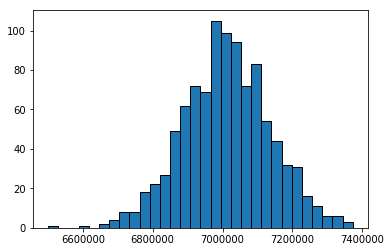

In [519]:
plt.hist(np.matmul(test_weights, loan_sims.T), bins=30, edgecolor="black")
plt.show()

In [391]:
values_new = np.concatenate([portfolio_value_distribution, portfolio_value_distribution_2])

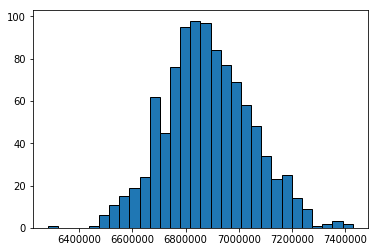

In [522]:
plt.hist(np.matmul(test_weights, pool_results_today_3), bins=30, edgecolor="black")
plt.show()

In [408]:
original_investment

7271325.0

In [138]:
def VAR(initial_investment, confidence, portfolio_values):
    
    """function to calculate the per period VAR"""
    
    loss_gain_distribution = portfolio_values - initial_investment
    
    var = np.percentile(loss_gain_distribution, q = 1-confidence)
    
    if var < 0:
        print("we can be", confidence*100,"% confident that our losses will not exceed: $",np.round(-1*var,2), "over the next 1 year")
        print("({:.2f}%".format(-100 * var / initial_investment))

    elif var > 0:
        print("we can be", confidence*100 ,"% confident that our gains will not be lower then $",np.round(var,2), "over the next 1 year")

In [450]:
def VAR_value(initial_investment, confidence, portfolio_values):
    
    """function to calculate the per period VAR"""
    
    loss_gain_distribution = portfolio_values - initial_investment
    
    var = np.percentile(loss_gain_distribution, q = 1-confidence)
    
    if var < 0:
        return -var
    else:
        return var

In [410]:
VAR(np.mean(original_investment), 0.99, portfolio_value_distribution_3)

we can be 99.0 % confident that our losses will not exceed: $ 759270.34 over the next 1 year
10.44


In [412]:
np.mean(portfolio_value_distribution_3) / original_investment

0.9642010910792317

In [477]:
np.mean(portfolio_value_distribution_today)

3771812.147571768

In [85]:
original_investment / 1000

1722.8

In [136]:
np.mean(portfolio_value_distribution) / 1000

200.68320480854928

In [421]:
value_today = 6883061.31

In [466]:
test_weights = np.ones(loan_sims.shape[1])

In [550]:
def calc_ret_var(weights, value_paths, var_thresh, todays_value_distribution):
    portfolio_sim = np.matmul(weights, value_paths.T)
    today_value = np.mean(np.matmul(weights, todays_value_distribution))
    
    var = VAR_value(today_value, var_thresh, portfolio_sim)
    ret = np.mean(portfolio_sim) - today_value
    
    print(today_value)
    print(ret / today_value)
    print(var)
    print(var / today_value)
    
    return ret / var

In [474]:
from tqdm import tqdm

In [555]:
weight_candidates = []
var_result = []
for sim_num in tqdm(range(10000)):
    weights = np.random.uniform(0, 1, loan_sims.shape[1])
#     weights = weights / np.sum(weights)
    weight_candidates.append(weights)
    
    var_result.append(calc_ret_var(weights, loan_sims, 0.99, pool_results_today_3))

  1%|          | 72/10000 [00:00<00:41, 237.90it/s]

3440960.427661361
0.018589317653555617
207408.36813365307
0.06027630148441363
3460367.1673063133
0.018499002152432564
193545.96848267913
0.05593220578189192
3621937.4747105297
0.018614477243948914
213947.10438712093
0.059069795069894154
3503734.1451460165
0.01866404886930837
181095.37709567999
0.051686392172923534
3429401.682943439
0.018658462476760368
194033.19697170332
0.056579314676595584
3537581.684724575
0.018575582500049745
187143.48099270073
0.05290152925677846
3334961.6921210615
0.018528425951760474
189363.71585693164
0.05678137662099946
3522027.7960662786
0.018581670518726768
192425.49823553424
0.05463486076130704
3420697.8049898366
0.01858715151499687
206837.44127133858
0.06046644663250314
3415910.887424592
0.018421080093034288
171948.26564514334
0.0503374564828835
3487732.7422790225
0.018614642316956975
177276.0943898012
0.05082846292688183
3349641.2744364687
0.01869437883614343
194960.19284418403
0.058203305032113746
3369684.9292511684
0.01848626836975905
157250.68554771866

  1%|          | 91/10000 [00:00<00:59, 165.30it/s]

3403368.454502956
0.018422141762936557
209125.45549392112
0.0614466104065899
3517937.496763995
0.01863997015279624
201092.36614321262
0.057162006524615394
3411293.98709095
0.018444465103109195
192071.71854124457
0.0563046513340932
3515299.819047341
0.01865569966792572
162821.3580733582
0.04631791495881093
3419208.6595144416
0.01857283451916018
165690.34570483817
0.04845868217015094
3512609.6578365834
0.018609054720047386
202728.39715618952
0.05771446784697676
3341727.1104961033
0.018556006487548442
159286.90399811388
0.04766604175960574
3470458.649558008
0.018656696714990074
188366.10240566783
0.0542770052683549
3332782.543295522
0.018670411588985334
163658.87629727734
0.049105776981011234
3672956.0227906886
0.018601320304526835
216186.68664054782
0.05885904576562029
3561564.280803882
0.01855667601555612
202575.68163894297
0.056878288770691385
3291168.4036771217
0.018452868040963168
179240.19607060414
0.05446096160571563
3570103.7038292116
0.01873762639596663
179781.01009894104
0.05035

  2%|▏         | 159/10000 [00:00<00:44, 223.42it/s]

3378940.4392828904
0.018556007849679357
184716.19203742713
0.05466689790975696
3450717.441432087
0.018555784986904335
167709.1343611414
0.048601236469694886
3307147.7243364295
0.01855710820319552
160862.34120033518
0.04864080912279532
3550033.5004134686
0.01845564194524027
181653.38624673124
0.05116948508389407
3316988.1178425634
0.01845635981061161
171994.53201068525
0.05185262228872679
3531991.232107803
0.018547133825722265
181771.60311495612
0.05146434154834507
3495633.8620707984
0.018575927125041525
169793.39281852156
0.04857299119935195
3540595.2202052088
0.01863186776855266
186125.43068361128
0.05256896626348145
3452470.6304664263
0.01850213822708173
163400.78444341777
0.04732865299460706
3622624.2264283793
0.01860755216573372
193348.71953287016
0.05337255741909966
3444393.058958197
0.01860098314404861
158796.5850571205
0.046102922151733366
3392271.7180707674
0.018420464595762447
173103.0840402853
0.051028661152984364
3369061.7162678507
0.018714788989346306
195512.4584660436
0.05

  2%|▏         | 235/10000 [00:00<00:34, 279.96it/s]

3495139.954603806
0.018537692000727284
177006.27894561767
0.050643545392929
3348794.2155405125
0.018617538836623888
195448.975981635
0.05836398518446693
3496068.4860601854
0.01850995879531063
211661.04893070084
0.06054259227891368
3531756.445979467
0.0187089755679261
190248.15043470648
0.05386785678590152
3436431.218675577
0.018587130709407654
196839.4908818031
0.05728020680642819
3504530.536567463
0.018574389739211005
168843.17714216834
0.04817854356821869
3491034.066039047
0.01871240770270389
188661.62242341
0.0540417592193441
3266743.2368007503
0.018610358793368708
177799.95913924795
0.054427283153534414
3492922.186814191
0.01876450412974553
186126.97956470813
0.05328689550180619
3258351.27690783
0.018454851596279364
181090.3046535753
0.055577281043015625
3506151.061773921
0.01885093625215433
213567.39485026745
0.06091220574569711
3458347.018391649
0.018653232811611176
184558.67028960935
0.05336615131683369
3339315.7009094977
0.018600965365517617
175759.8677837536
0.0526334984547533

  3%|▎         | 335/10000 [00:01<00:27, 354.41it/s]

3464296.2343434854
0.018561998235223486
192954.08119520702
0.055697916154613586
3532195.5667039817
0.018494411468615708
202402.5343735726
0.057302187987977586
3544906.9725194853
0.018394599818600393
197387.64878588318
0.05568203913841866
3378204.0825262507
0.018585234746850997
183132.4078270323
0.05420998949539019
3537318.227620186
0.018675415124692025
230277.87998706946
0.06509956559435545
3565510.9222991103
0.018617332948319815
192767.36583750267
0.05406444406940775
3390384.720172461
0.018578808709976965
182935.15260698186
0.05395704844896669
3410415.6149328756
0.01862165741465328
181383.7097824217
0.0531852214692583
3469405.735456874
0.018771908391434933
187588.4383155493
0.05406932847271795
3609962.6117234626
0.01864007682771455
209469.22204479692
0.05802531620813448
3370541.18273986
0.018590943094030723
173140.80177781382
0.05136884327788287
3257100.569088633
0.018342587177163045
164378.14479100707
0.05046762950798341
3412025.2538448367
0.018586185205022858
190120.7510766921
0.055

  5%|▍         | 454/10000 [00:01<00:21, 443.10it/s]

3295558.1841628198
0.018396590671243
177394.10992772866
0.053828243961892785
3402436.034862058
0.018605533247041017
170347.44390158006
0.0500663178252773
3632672.1549673313
0.018634696037020358
207040.5387215065
0.05699400603448302
3576168.620965915
0.01867844010357529
190890.06295012138
0.053378373108861524
3517875.555771442
0.018592254106076646
185834.6152631433
0.052825807029547193
3349790.83525317
0.018363029079805488
203754.68381534363
0.060826091489364374
3319073.269156565
0.018715870390334
206426.9692075994
0.06219415857006861
3272800.799175413
0.01855760281784787
171448.04169787018
0.05238572471048857
3599101.455348374
0.018583455644604552
197368.02284615915
0.054838138156084563
3269988.4485098138
0.018621184631186907
151121.28377868276
0.046214623127354214
3257779.662489684
0.018563686206500764
161706.71125033617
0.04963709274517218
3409277.513597115
0.01845751163142186
181470.23362916513
0.053228354953626704
3295548.62607643
0.018603707633488342
188056.71535521478
0.057063856

  6%|▌         | 562/10000 [00:01<00:19, 487.37it/s]

3070479.884100322
0.018499722494539513
177563.02251493005
0.0578290785861825
3549568.463444087
0.018577010936240604
191217.70190834897
0.053870689881781744
3372461.800044613
0.01861272837285581
212497.13216863672
0.06300950011229947
3518893.998998958
0.018503247516119686
211588.2378655396
0.06012918772936367
3240936.120214211
0.01850008095151124
178709.15399588374
0.055141214564905366
3378640.4507990372
0.018595202344986028
178479.7479291567
0.0528259074998486
3365298.3258096725
0.018764594817376995
191296.25218075607
0.056843772426841604
3373792.307687475
0.01855043674959219
166510.40027465887
0.04935407549992057
3549788.9165458446
0.018624300876126484
183008.56326378198
0.05155477341505144
3514074.3012626837
0.018663080539668125
176256.40567020836
0.05015727914656659
3494319.746794482
0.018676859782513072
187674.61476696513
0.05370848358657751
3530426.9609098653
0.018631728539375177
168536.01985756244
0.04773814094545866
3611263.0416670954
0.0186017162870678
185690.89254434075
0.0514

  7%|▋         | 691/10000 [00:01<00:17, 545.88it/s]

3355798.574368667
0.018592258559781527
178358.2217067618
0.053149263209373854
3522326.056565376
0.018669283825828383
194512.22398916518
0.055222662770417756
3503504.2817283897
0.018527027258735257
168032.48913024235
0.047961262672511024
3203973.6194452164
0.018679819282256545
200967.49297931837
0.06272445308526506
3282730.015323168
0.018668612747895098
165489.82536957623
0.05041225583496076
3498184.04537614
0.018595577364718875
176118.8652601982
0.05034579741251467
3318600.8168765944
0.018609930579271707
165392.40293126064
0.04983799259319321
3259455.05556211
0.018433388171553242
149317.87013987402
0.04581068540431933
3192625.107941786
0.01869722631303972
193896.21648855138
0.0607325351185852
3359502.9658430205
0.018660140408414957
179585.51254235144
0.05345597678235327
3569466.707018476
0.01866666968418179
172121.77796773805
0.048220586461642304
3290785.804520458
0.01850609548665841
172186.3495741395
0.05232377912218171
3584225.123927541
0.018633663959701587
201193.17693943015
0.05613

  8%|▊         | 829/10000 [00:01<00:16, 544.34it/s]

3417542.6030689045
0.018755204094715056
171170.89479607146
0.05008595785824658
3608676.871918097
0.018593605008062692
182142.82003157242
0.050473574247937365
3235298.4940183894
0.018734990320707644
184867.61252685316
0.05714082112319692
3479702.901809148
0.0186304015940967
190956.89620683296
0.05487735637072685
3419830.2509074113
0.018544514712062855
197219.73036141784
0.057669450204169616
3344509.664247341
0.018594278614889014
177823.49165343444
0.053168777939068206
3611781.721788203
0.018552619469645513
190765.1713184017
0.05281746960720354
3364174.0986540224
0.018510197609259895
194140.86645671196
0.05770832922540664
3533146.3995520095
0.018561983121600963
191509.440646058
0.054203652775424396
3366385.130996787
0.0185725265633051
180697.72070395979
0.05367707902466144
3536929.912859695
0.018373390549585793
173178.74884191068
0.04896301400043616
3307775.5413025627
0.01863015512065455
187250.6482626645
0.05660923660767121
3493990.731109859
0.01868923791118235
186991.81186419752
0.0535

  9%|▉         | 887/10000 [00:01<00:18, 501.20it/s]

0.018586564058836304
176952.61768799627
0.0494250045607547
3354191.810244733
0.0186724352145807
163507.00036552473
0.04874706326159526
3224115.341132934
0.01861947134503351
185336.85387210042
0.05748456065066648
3304733.9049658617
0.01856611077031206
139476.10835632842
0.04220494368600888
3429091.1019554967
0.01851676324845855
140590.03994908958
0.04099921401006691
3433115.080525809
0.018726794504473867
174278.26829154522
0.050763887665791006
3467610.0925651756
0.018495262330957794
213360.25061590035
0.06152948137778271
3411008.3842242435
0.018574214060165916
183836.82558592386
0.053895155003476594
3517670.6937231747
0.01839728156996693
203564.29781592227
0.057869060392479674
3459169.204217176
0.018609320604017952
192067.68750391106
0.05552422450736311
3440213.6978636193
0.018565331031907818
177484.97342986177
0.05159126409504164
3457643.141146947
0.018673491848268265
202874.55728494178
0.05867423241880466
3388579.485906451
0.01854836310715699
156179.68990693075
0.04609001812013048
349

 10%|▉         | 999/10000 [00:02<00:19, 466.53it/s]

3614338.774438158
0.01872271881704572
179611.01863574522
0.04969401869742147
3661188.65394554
0.018591220171106093
175634.1141715487
0.04797188311568531
3555565.4075582568
0.018611439088337334
190507.70443959112
0.053580143409714426
3367763.511241483
0.018576540817661736
176196.84556622253
0.05231865152588158
3560146.357093906
0.01843576495557312
180009.63598705168
0.050562425791391016
3483925.5930126454
0.018640781271420288
174430.19029008324
0.05006713996416
3254069.3701831773
0.01859321644359069
152074.5420219323
0.046733650921944474
3304166.091584213
0.01859259219735841
164649.91164582997
0.049831003370319996
3328847.011635594
0.018613868098049793
199950.294594696
0.06006593090514319
3370033.822593335
0.018556846107353205
199399.43065696876
0.05916837668517087
3456441.7156356517
0.018615734840917338
180097.0005291721
0.052104741044664664
3327836.2234495636
0.018547718908053994
148713.51924954596
0.04468775181952696
3292635.5259270733
0.01859612471445721
144778.41754682353
0.0439703

 11%|█         | 1118/10000 [00:02<00:17, 510.60it/s]

3670118.816769867
0.01858472366416658
188433.56216257904
0.05134263264218311
3425548.9494715887
0.01875261747822717
170538.07293426775
0.04978415881652319
3462311.925305907
0.018699099059719896
173372.72941084078
0.05007426631426997
3418512.002531458
0.01866012708986751
177760.521987739
0.05199938507049404
3513949.102517964
0.018472107804996463
187543.92546626242
0.05337126975796988
3484935.5711954962
0.018524808908854284
171183.30638310316
0.04912093864747671
3477951.5425252733
0.018564862833702917
193653.08873603048
0.05568021473796116
3561596.300755336
0.018500938724468514
178655.07787483436
0.050161518259929
3436824.257634771
0.01867401234095221
191668.2326334036
0.05576899435798036
3304597.208560599
0.018564482660096065
206833.94441234437
0.06258975946494735
3434891.987720458
0.018473599338398077
177057.437760969
0.05154672647464293
3329706.8972294503
0.018532762971784623
192480.68271499418
0.057807094935338484
3335270.9897604636
0.018580125944181305
191971.8134851122
0.0575580857

 13%|█▎        | 1268/10000 [00:02<00:14, 609.05it/s]

3542319.890947305
0.01866146224208373
179127.71375336184
0.05056791008941279
3383716.0448456076
0.018682753354687744
181375.07652122938
0.053602333682082115
3458423.010378439
0.01850387780091415
175582.0044692758
0.05076938360124509
3286725.379645781
0.01857305533370112
191180.05508171298
0.05816733465645279
3612758.5218301853
0.018748549853168
193093.99635642476
0.05344780039674652
3377093.221854174
0.018572425404878017
170602.73084949792
0.0505176255560483
3515727.0987153323
0.018694876372275702
208978.439858118
0.05944102997484645
3590120.79489348
0.018547885650635476
157381.06190317596
0.04383726088744195
3403512.499853765
0.018542373463744384
147810.62610049004
0.04342884772917416
3644215.9529791228
0.0185226951638609
202842.87232265505
0.05566159496031851
3377754.8301543626
0.018664078576337242
179250.01571296167
0.0530677993893269
3258255.8778953585
0.018723999915325494
184934.85096303694
0.05675884825917784
3627410.6926447502
0.018468086892134614
204959.85642993692
0.0565030744

 13%|█▎        | 1333/10000 [00:02<00:16, 520.53it/s]


0.018635315233396222
180555.05201141542
0.05595890672604206
3309133.197722248
0.018611320141451643
160458.933478646
0.04848971736438218
3473898.168525483
0.018566231647957704
195921.5013204535
0.05639817053233128
3380372.9802923086
0.01860702225578879
161446.70641450892
0.04776002747500019
3355855.9579112134
0.018571255665097913
190388.3011842432
0.05673315647991836
3546671.2357833283
0.018582453133004165
198844.3393459607
0.056065061046472596
3428978.8083302905
0.018600125833664122
176621.47034401674
0.051508475326513
3232486.8336439515
0.018546251844658863
190272.42223468545
0.058862551350346314
3361601.4771696506
0.018540912633815253
146097.0626981366
0.04346055405150082
3315716.780656304
0.018513462047264877
204374.32730989275
0.061638053196280365
3393697.518616644
0.018637904698273658
181578.08410091998
0.05350449859035632
3347034.535643844
0.018680210063501
164620.98161715115
0.049184129970587305
3471103.808125928
0.018642875873656792
189008.79824212068
0.05445207308397031
34121

 14%|█▍        | 1390/10000 [00:03<00:20, 412.24it/s]

3486756.380011579
0.018655596752321296
201278.51864956022
0.05772657929398893
3420428.7245820602
0.018659513532837926
195537.59492323626
0.057167568941852126
3309709.951661831
0.018585430932252046
174568.76203174298
0.05274442914373529
3309263.139622848
0.018598255116161796
182788.14059642795
0.055235299486416804
3502251.427562312
0.018522261246915996
184334.7970565511
0.052633227759108794
3416871.948265833
0.018703004783677528
181864.26497146927
0.05322536744866045
3373031.303325514
0.018778440748513946
145378.34433015803
0.043100206092611025
3414201.711485077
0.018565262454565006
164918.4440281076
0.048303661577268946
3445820.615433031
0.01870963273887604
177192.90384451294
0.05142255608167965
3375453.2144957543
0.018672660105406375
175287.3697438161
0.051930024978883195
3374682.734466042
0.018513877852886593
187559.15569795007
0.05557830778650265
3441358.444854782
0.01860151727875708
181344.75816644574
0.05269569010969391
3484099.3132054927
0.018706825965786936
180111.93329665743
0.

 15%|█▍        | 1487/10000 [00:03<00:20, 421.48it/s]

3501533.2795411064
0.0186485927795737
181694.6234921035
0.051890017597066934
3653556.0294225146
0.01868415163897804
204908.40139533643
0.05608464732583408
3425888.8195684263
0.018765406566854662
190662.915575905
0.05565356192730259
3293434.7386158654
0.01865753155355054
193301.02511540192
0.058692836037990144
3355955.011153815
0.01876406672178872
176995.80003267652
0.05274081429709732
3399290.1590050696
0.01865013166201605
186666.30685264865
0.05491331958178103
3248701.5702604325
0.01859606673300804
194676.91141220593
0.05992452898546776
3349923.918998529
0.018500969796209736
164322.95657167188
0.04905274285178297
3459925.160479093
0.018640887097791804
202732.85190922074
0.058594577196331175
3410480.606071801
0.018614761176548728
181411.7486877836
0.05319242934993085
3343855.7972713853
0.018503265575958102
168968.77085529835
0.05053111769747317
3204830.16697126
0.018589692003990892
171020.69639888618
0.05336341942902706
3338936.199349575
0.01847247843467358
175837.64584454588
0.0526627

 16%|█▌        | 1613/10000 [00:03<00:17, 477.89it/s]


0.05179959310855731
3319655.3949445337
0.018570228226249732
175680.10025306192
0.05292118589194625
3279229.9356403723
0.01862104738633522
157832.28018870388
0.04813089758461301
3357390.0611072937
0.018597028506247965
152188.48320047904
0.04532940183610542
3474736.1418018606
0.018443166165575547
194550.98270102934
0.05599014565754708
3464028.875347315
0.01852511168620556
193002.15375570836
0.055716092648435946
3445684.7466384917
0.01869404972289459
203252.75574248747
0.05898762385060759
3372758.9500028496
0.018610267119273324
180271.76363649775
0.05344934705053424
3331656.8435783605
0.018680481209500204
197842.47959680523
0.059382610180318825
3545499.1178553323
0.01857334397592
225021.5470430181
0.06346681794667414
3538353.729041277
0.018551235963642995
177485.78124802155
0.0501605534210147
3380811.0661744424
0.018651276076993333
169130.12691056498
0.05002649470795309
3426312.8031534273
0.018525174392586004
170187.66319063108
0.04967078984557331
3575608.200594162
0.018500262168848366
2

 18%|█▊        | 1784/10000 [00:03<00:13, 615.58it/s]


3406463.301116279
0.018688082882111472
184044.62974346496
0.05402806766864465
3284443.737385322
0.018566534218589278
218007.61778813414
0.06637581131521697
3451375.5060549416
0.01840424440877505
176631.94101479885
0.05117725982146061
3325182.619366563
0.018597814242226694
181809.56138822922
0.054676564327424335
3326669.229443845
0.018672417662581594
200586.44717083816
0.060296480754827665
3245439.120204125
0.018733998113605176
154690.1875933278
0.04766386977661082
3257233.106384593
0.01863881730068371
175042.35297884475
0.053739584261175345
3427190.6409961865
0.01865804599937699
171117.8897386395
0.0499294925971496
3621776.3362614173
0.01866685120910103
193876.30548622226
0.053530722906636276
3463292.735500433
0.01851708574057549
184373.54743829518
0.05323648952581361
3322902.742054776
0.01864109184845783
169727.67184357604
0.05107813409507794
3585793.4289773926
0.018542025431286708
190744.93488572145
0.053194624471192324
3514968.3290802306
0.018514827701274283
199759.72778870366
0.05

 19%|█▉        | 1876/10000 [00:03<00:11, 682.29it/s]

3615510.612476563
0.018547744469310016
209214.95879370035
0.057865950682521074
3251351.858671716
0.01862135494392815
171952.31301734547
0.05288640556042238
3492554.5675585466
0.018558841195094895
197989.05394144382
0.05668889350520502
3311703.502895768
0.018595528961151596
168673.60691874893
0.05093258100287662
3242403.6001011007
0.01875000628169125
169049.29862292483
0.052137031496527375
3424415.119271547
0.018587292832755727
196852.33208231736
0.057484950050154096
3520984.2151803137
0.01857686837814752
181581.77119694804
0.05157131077557217
3488252.986512237
0.018478679681037148
174547.7563546179
0.05003873200410877
3699064.1528578126
0.018401424656006467
166403.84738669932
0.04498539103684901
3278831.7898245393
0.018614281103414128
166781.5137981895
0.050866139066900566
3482288.4188133846
0.018535050442783977
181566.65279888126
0.05214003866479027
3541819.6295399284
0.018749142728354807
181924.61888798384
0.051364732797422354
3464143.559016342
0.018396548168336916
196520.26308339922

 20%|██        | 2021/10000 [00:04<00:13, 574.57it/s]

3216112.8332446073
0.018594346834737388
161233.11132715284
0.05013291500861032
3448565.8963964977
0.018484753227811273
184897.80460745876
0.05361585370912112
3431362.8070608187
0.018484503153804035
178127.36361740113
0.05191155049266813
3332512.8484453303
0.018637536718758417
188052.49734852227
0.056429639104392866
3483558.0758804022
0.018651390034792773
197912.88608208095
0.05681343091490222
3468534.790915083
0.018366515233761784
180280.43204076245
0.05197596187097784
3374249.880640491
0.018792336237316798
195117.67860413974
0.05782549766797444
3493182.82639305
0.01860549491290638
178532.2910050133
0.051108773825434176
3388847.4488837807
0.018712547632708944
172008.3972890844
0.050757196918303465
3520623.44447306
0.01864726935527173
177143.86330122754
0.05031604944269781
3304568.051187339
0.01849282695718927
163772.88120174862
0.049559542628545554
3186421.9418512015
0.018563601964962616
173707.97188835923
0.05451505640443866
3327534.786740742
0.018614653052473232
161949.9264577906
0.0

 22%|██▏       | 2188/10000 [00:04<00:11, 668.45it/s]

3589955.9724788237
0.01857031875705281
183735.12851510264
0.051180329208392945
3530887.052555009
0.018615154547259857
190902.83452642534
0.05406653673282607
3341143.958998193
0.018580150757879273
190943.93546266787
0.05714926917423828
3500336.479333167
0.018711462360311123
170850.01852118416
0.048809598599998595
3359813.7642080383
0.018574545528307226
179982.1210448407
0.05356907664412326
3379476.9915876943
0.018567133607374987
189538.56079922648
0.056085175685773904
3363272.784678613
0.018738813931500165
180174.6402029758
0.0535712241432694
3507799.133907911
0.018467245146363498
184377.12003470873
0.0525620518724802
3428606.54819918
0.018747927825532626
197430.11282060278
0.057583193068420094
3463978.506986993
0.018433681539520883
197439.7008994246
0.056997957839859656
3390410.490056706
0.018559533826932494
187109.70272929696
0.0551879199518898
3371142.845437389
0.018536304807054087
177880.5951504809
0.05276566532659098
3460587.291181588
0.018584766965564818
184565.7652891255
0.053333

 24%|██▎       | 2371/10000 [00:04<00:09, 773.23it/s]

3376475.2836651145
0.01858491260110941
205671.0080264964
0.06091293160696367
3443446.7263723067
0.018618654782391997
169071.53768385926
0.04909950730150462
3355859.4402060714
0.018498876440434353
182479.93778899184
0.05437651398706568
3394367.652557063
0.018473864129730268
201924.244611005
0.05948802996012832
3437473.730445244
0.018604902524738943
194920.0629822602
0.056704451660496875
3269804.851544876
0.018513617837697127
196416.5087961633
0.06006979551191348
3556813.226945002
0.018567688804281775
194764.85809079054
0.05475824724653222
3467816.7585052038
0.018630333635960193
189450.3440575555
0.05463101347350826
3476039.457998289
0.01864194673626498
189775.26150668444
0.05459525526098843
3408349.3864499177
0.018567042981432965
204286.20012820905
0.059936989130386746
3490808.1509917146
0.018608347763744783
167622.02573536255
0.04801811456975723
3318484.9561721305
0.018641671040723784
177417.76822645936
0.05346348426153801
3557157.816835369
0.01857299721004848
171670.32156041538
0.0482

 26%|██▌       | 2597/10000 [00:04<00:08, 914.29it/s]


3298492.717408121
0.0184422207088547
175336.94219934684
0.05315668616577166
3460413.52053517
0.018751800982939562
163581.76482394926
0.04727231697980724
3402703.1200390016
0.018662583327322582
180751.93614179592
0.053120101802981906
3456427.3375633685
0.018624843959383578
204565.11471307263
0.05918397661363313
3533880.530016626
0.018513256747935334
186416.69586021153
0.05275127279397147
3305936.067165224
0.018584208406438037
181590.8270786443
0.05492871712862703
3540298.976526569
0.018616930165953727
184692.88740807737
0.052168726040556564
3493249.323348039
0.0186603581735649
196848.67806028778
0.0563511675919032
3256981.619087755
0.018423801485983243
194167.25051427295
0.05961570350177692
3461291.9866139838
0.01863784209596461
184019.13411794882
0.05316486873387585
3535099.4224801166
0.018520187166732066
162534.44132266755
0.045977332430621826
3541527.9159035
0.018647200459475714
179345.38676262493
0.050640681372935356
3471132.8203299446
0.018677771450367295
181074.30204104717
0.0521

 27%|██▋       | 2695/10000 [00:04<00:07, 932.95it/s]

3448650.8546023155
0.01873809601832698
177147.68851752538
0.05136724359356852
3560779.8083468513
0.018517092208459943
200130.42061151954
0.05620409892866509
3289649.700541862
0.018743730184116646
158732.46426417553
0.04825208721707651
3395039.829773293
0.0187129347971588
209458.48453521437
0.061695442480037464
3346829.890110525
0.01843451681464757
200057.58461988936
0.05977524737992665
3380453.067599059
0.018548358155819806
184202.72785181986
0.054490544364412204
3366639.6033948637
0.018509520387386957
203208.6348043144
0.06035948564241987
3538116.509388262
0.018761692303251976
207883.24885791412
0.058755342936362774
3600253.119832158
0.018655353143899142
192986.47265138384
0.05360358458918043
3295962.7850946067
0.0185557885063775
204726.4020199789
0.062114294174017044
3343676.9995332067
0.01855620109814914
203721.55263586238
0.060927401978212274
3516756.951818521
0.018659611337038706
170164.224598796
0.048386688909736505
3411248.2230474246
0.01856393473771633
178347.33559463656
0.0522

 29%|██▉       | 2882/10000 [00:05<00:09, 770.46it/s]

3556868.0759071833
0.01856829505502792
193380.95366344578
0.05436832334978399
3559856.0685429685
0.018794866188287046
182269.38137106854
0.051201334509479335
3386995.812897664
0.018637908121093377
156632.0647618944
0.04624513091083261
3495715.730077611
0.01870535654253796
175776.19922292317
0.05028332187040296
3298677.316335015
0.018666333035917786
184501.84337133862
0.05593206781933093
3528835.546272549
0.018654817444616698
190207.29542251138
0.053900866993766325
3378559.733541999
0.01854867575733192
174256.01490168402
0.051577011698709346
3320733.7603603313
0.018586449968659813
169250.5597494414
0.050967819754112444
3490429.5902541718
0.018682685135092802
184438.3256021398
0.05284115345489868
3390682.8472455773
0.018560668539793657
176217.59533998513
0.051971123009377174
3398971.178136324
0.018604193581783886
185443.27102265653
0.05455864769183955
3370998.0446296264
0.01846713830891898
169656.95195742187
0.05032840414360495
3454722.3252323796
0.018613892983999118
179637.53920951945
0

 31%|███       | 3108/10000 [00:05<00:07, 919.77it/s]

3379770.9025024357
0.018733237477647914
175577.3744605726
0.0519494899286139
3193050.570529633
0.018611784893421617
168574.15599354624
0.052794076470133934
3524439.829775231
0.018529108546823488
189840.66723586878
0.05386406816540141
3430260.461744526
0.018683688760631877
174266.20061880865
0.050802614717537276
3478315.7070550295
0.01883621311168144
186436.53412533173
0.053599658520698555
3568066.034405339
0.018610804933698134
208410.15023921386
0.05840983553263972
3519098.593448097
0.01850622925456482
194720.28050463327
0.055332431113798854
3313427.1335577415
0.018653953065977894
166728.71710291004
0.05031911383060585
3411077.141125759
0.018701779638226522
187868.9659158156
0.05507614109653737
3631922.3361576675
0.018659455178930227
178699.98585226203
0.049202590064553735
3343124.529184264
0.018597272983337416
153698.72989281203
0.04597457514701528
3444764.338022801
0.01869752936622039
201624.22519720314
0.05853062950394158
3344247.004590612
0.018411147369135725
172847.24792582128
0.0

 33%|███▎      | 3328/10000 [00:05<00:06, 998.95it/s]

3392300.9311787537
0.018526513081554192
180790.1468928906
0.05329425382967713
3433548.1298931506
0.018574532030708912
199518.02532549083
0.058108410826820035
3417340.3336239923
0.01868864168655155
199484.00466423243
0.05837405268110517
3479180.2584387413
0.018666436346510048
212798.38865952427
0.06116336977464229
3507326.7917880737
0.01851535156681524
198784.7861787878
0.056677007299181584
3451930.2111460837
0.018524752048337007
193126.91982316252
0.05594751574048827
3317274.5289445883
0.018684877084277112
176204.28289811194
0.053117184411677995
3307411.0053136838
0.01845073740966831
188778.61712224252
0.05707745932360718
3483850.5818528295
0.018498104861287584
168947.27824334038
0.04849440992773246
3451269.8570972667
0.01858930780065895
202540.68670838926
0.05868584465856246
3233042.9669635827
0.01859393519257911
188718.2418894621
0.05837170857852934
3486206.5194661757
0.018472986871565646
187451.23570043148
0.05376940082400365
3460270.970541679
0.018635846180352075
205568.69466242028

 34%|███▍      | 3432/10000 [00:05<00:07, 921.57it/s]

3561443.831632913
0.018462738512098457
198529.57604680548
0.055744126661062675
3307663.5900799674
0.018694202437349736
166035.55124648506
0.05019723037870091
3504287.109443264
0.018484797839013325
174091.23184107282
0.0496795001105749
3342839.7497783545
0.01850698317366861
178071.74379985817
0.05326960223315076
3423251.37612621
0.01864945643184629
180359.9608229639
0.05268674164006655
3501859.3004033896
0.018547184192862505
186595.00951407198
0.05328455357774584
3564258.561774381
0.01851914062195654
190707.2459233713
0.05350544653764744
3469930.740479184
0.018504669743443912
206960.04993983265
0.059643856151218824
3612888.271211008
0.01862079668105856
199177.1092896915
0.05512960665759229
3407560.8238537684
0.01863202946608081
183463.36569800784
0.05384008538122604
3382259.479470825
0.01839832745607846
178470.41623075126
0.052766624593413525
3640797.744699129
0.01848902297708375
220885.50187477114
0.06066953381202582
3448439.5084153
0.018570557689009146
196815.49783680466
0.05707378579

 36%|███▌      | 3618/10000 [00:05<00:08, 762.95it/s]

3380158.7442469974
0.01850825860363883
198444.331086284
0.05870858326521931
3479899.205030002
0.018503352086071692
159973.0824574491
0.04597060806422693
3519016.327178945
0.018540463915108062
179749.482632268
0.05107946821501848
3548972.3486195076
0.018694576161579386
179032.60656890788
0.05044632332470797
3351103.2225527833
0.018535331706834263
167388.76816911733
0.04995034681193882
3448943.5751077347
0.018602926684479843
195267.4251761168
0.056616590246773534
3362725.931629159
0.018672587787405975
187666.4108682146
0.05580782219064007
3561138.4823347996
0.018827400705988016
199224.74521931427
0.05594411624472856
3670024.979160556
0.018578856613085722
198054.99550717496
0.053965571523841786
3515181.833026219
0.0185151493235139
185119.00180365262
0.052662710094938024
3444436.4097980643
0.01846898219453646
176171.61383261005
0.05114671687114653
3436058.0835085553
0.01862949388378451
190443.6999201233
0.05542505257235391
3424847.970851559
0.01847555789065893
179460.60151279485
0.05239958

 38%|███▊      | 3777/10000 [00:06<00:08, 705.31it/s]

3204042.840057481
0.018527316589608604
177435.558140087
0.05537864722710879
3520418.860119728
0.01844785520174553
180323.08361421485
0.051222053618949805
3479625.5714877667
0.0186252604645401
179193.96407937165
0.05149805931640931
3484514.069532408
0.018542342146977253
159652.3584929442
0.04581768226706233
3665192.5315158134
0.018493995529845358
175193.209500946
0.04779918326104723
3423536.641686047
0.018667903898629077
169623.6021816806
0.049546308374880776
3492034.9482821357
0.018444416177158134
179313.83442781997
0.0513493814018188
3467077.058129826
0.018635801965702872
180558.22251551956
0.05207793755034518
3531856.0648477613
0.018588991571333986
203785.06390130875
0.05769914179956617
3540353.7774012727
0.018677237950773935
189451.93831700445
0.05351214884973104
3617189.7200687807
0.018545331302295784
202538.9190889785
0.05599344650496442
3536127.7519887476
0.018586652846414545
197335.86900474905
0.05580563906204059
3386287.9515614714
0.018403168545619235
163200.16072793686
0.04819

 39%|███▊      | 3851/10000 [00:06<00:09, 681.33it/s]

3495691.418591132
0.018513404284664182
202279.19573621568
0.05786528944186391
3467335.542261683
0.0186556557082375
219624.78680813545
0.06334108254918934
3356096.07190509
0.018594734923604504
216161.21853417126
0.06440853119304991
3409929.8231853154
0.018558800154716257
182867.55414234032
0.05362795236985798
3462841.5561679006
0.018451861162916222
166198.81852201052
0.04799492434933461
3275038.615357103
0.018588794904566556
192010.36719957922
0.058628428470802275
3196986.4310504263
0.01862384208611297
145646.66517794097
0.04555748618866868
3561119.867501329
0.018601366712664248
222759.8589338634
0.0625533167155543
3468521.8473418374
0.018608609391284676
171537.70699453767
0.04945556480377905
3465826.470538085
0.018724166497302602
169972.3787514572
0.049042379991133325
3285801.6657297984
0.01862670202683754
172756.87578133142
0.052576781363022705
3377975.900220789
0.018574751815164846
172125.50637716035
0.05095522036315001
3361549.6243563406
0.01862658078130104
143435.94897205656
0.0426

 40%|███▉      | 3989/10000 [00:06<00:09, 654.98it/s]

3427122.6226351904
0.018563933960514378
191936.46453937874
0.056005134824091744
3747955.4269275437
0.018659933065159364
218359.07021256338
0.05826085034089301
3300358.7096262947
0.018581575615756782
166325.50350150332
0.050396189667618475
3690026.309362075
0.01852267622619597
203247.7185844806
0.0550802898257974
3409808.6360450084
0.018535562877120437
182785.1188086475
0.053605682405877625
3506981.3054091423
0.018655387262246404
203304.5398471118
0.05797137827154549
3590304.7750466224
0.0186721926366982
194281.30219986138
0.05411276044032739
3446588.0443686913
0.018666798909869525
180602.87870411054
0.052400483138445815
3593464.314074944
0.01847725069953251
204740.75315543532
0.05697586931738912
3554272.1922398023
0.01842586875071124
175126.36753795878
0.049272075425264225
3455211.0555224037
0.018547652233841822
163555.58346150513
0.04733591691890922
3307547.394858808
0.018543818879155374
223468.33528529882
0.06756315438824972
3446278.038732872
0.01860926417608964
159337.34016742426
0.

 41%|████      | 4121/10000 [00:06<00:09, 633.34it/s]

3387921.591021726
0.018420275587538386
195542.92177876676
0.05771766451058719
3576326.275873507
0.018533730404323934
180232.4161374793
0.05039596564590799
3397548.0125952074
0.018525249837332506
193497.67303204024
0.056952152645000476
3400672.2426721565
0.01864609201708262
169405.5879984589
0.04981532353301551
3410857.1342066694
0.018601426716794822
205842.84509972858
0.06034930136339631
3334347.2719191015
0.018508584145131436
203504.68146466068
0.061032839374146074
3595956.3469692497
0.018662566415584392
194064.36997266187
0.05396738760085994
3670478.514302325
0.018646009214002557
193346.64429075248
0.05267614114545588
3333832.2933311644
0.018591082198961262
198268.94398607762
0.059471780983910066
3293421.966004181
0.018496755124966378
188101.1231987122
0.057114188567500855
3429663.323258511
0.018602726536439716
188926.77381986298
0.05508609913359202
3288361.836562212
0.018656055323887425
177104.96590176522
0.053858113767345624
3425121.8495409777
0.018584509869205103
194580.8586792610

 43%|████▎     | 4268/10000 [00:06<00:08, 680.82it/s]

3375710.354244168
0.018617338420945713
190151.13056195813
0.05632921981084291
3324010.0215410073
0.018604006162199312
175255.9094387764
0.05272424219633609
3504506.126211652
0.018689510630239558
182484.75780258942
0.052071462063573055
3598780.360079168
0.018536208256256344
187577.8741301856
0.05212262360075211
3251731.479335771
0.018694882078602752
177930.8798630188
0.05471881088390627
3584289.2324729427
0.01864787347881287
182519.3293470192
0.05092204270052501
3584725.6251875036
0.018531905181890598
182114.93228675768
0.0508030324572559
3525696.7527008266
0.018512098841087146
205043.3819237235
0.058156839996704755
3440673.7886776305
0.018540115865378258
159359.2911337279
0.04631630341072676
3511854.040027844
0.01863336109123889
166292.57834822242
0.04735179094940516
3492501.975516467
0.0187118574410581
184176.58491597322
0.05273485489975633
3395009.3212607205
0.01858469116661937
160332.46207264057
0.04722592691236025
3430068.151263958
0.01853009789653749
186877.91507934325
0.054482274

 44%|████▍     | 4419/10000 [00:07<00:08, 655.05it/s]

3567963.4450527984
0.018610611136670414
203030.0275615538
0.056903617620597396
3456668.850797746
0.01845977052164513
177794.65998598764
0.05143525968504486
3250336.243030326
0.01843573667384244
163688.65655443168
0.050360530208352496
3513593.675839421
0.01860782707553528
190783.03087260455
0.05429854686513381
3403022.5926729874
0.018504780177711566
198888.6978412171
0.05844471860675927
3392668.203733788
0.018574952931577387
219487.55189826674
0.06469467060077097
3571536.8118724446
0.01861501059765783
216239.27192775838
0.06054516117793867
3402418.0233491454
0.01848575913789771
173856.3138023396
0.05109786998812257
3567944.956231382
0.018582807234058432
194028.96904428658
0.054381155377808396
3380236.9085866665
0.018552192268404974
180519.9127286933
0.05340451501198823
3723855.6349965534
0.01868882062264496
194290.00560222418
0.052174419377673864
3427711.305928942
0.01850370924318071
189248.31990466715
0.0552112774425672
3476219.4226781297
0.018542727557405155
194370.12772168533
0.05591

 45%|████▍     | 4496/10000 [00:07<00:08, 684.31it/s]

3404211.102550079
0.018551652408304056
175941.85471991828
0.051683591122806995
3666066.2611378995
0.01858506509467871
176153.48734482544
0.048049728181985905
3321463.9720046516
0.018735858710454408
169718.88529962412
0.051097614404407105
3489410.9271680135
0.018508188863818286
199906.99582936938
0.057289611341824045
3502917.7523320965
0.018545534221276784
164730.65234291783
0.047026697167881555
3449036.590228999
0.018777912239470413
188273.85699029546
0.05458737594250776
3341305.363806192
0.018512472302839873
175095.27490031614
0.052403254367885524
3367612.939156555
0.018622794193148162
164188.18944516152
0.04875506550532608
3461338.5153224235
0.018548516325690184
177148.18266461286
0.05117909787801021
3482649.319001197
0.018544354887318832
204127.95501628102
0.05861283646980101
3637038.98521296
0.01862135172383355
177235.30133880142
0.04873065756495424
3501971.6150569324
0.018580660869364666
204714.107971806
0.058456815324152166
3629734.2571505727
0.018644372911962626
170485.896115177

 47%|████▋     | 4654/10000 [00:07<00:07, 687.73it/s]

3573968.1073275977
0.01856280969763439
208956.45927725494
0.05846623500887931
3411383.354997726
0.01856103121658754
185842.88915606766
0.054477280861385785
3402806.7178087127
0.018660516143625416
187497.62352237376
0.05510087379958965
3613795.9279042436
0.018567088392661746
200645.26541220408
0.05552202432431339
3599026.48921294
0.01862574897791477
176675.82415142228
0.04908989269208157
3481900.8920170483
0.01843123568193252
204862.80984469815
0.05883648506894236
3317902.5750116603
0.01844072435236935
197515.1487651791
0.05953012311233549
3396635.457954525
0.018429813455781416
182167.7786332159
0.05363183093628731
3407869.6976978094
0.01863954389279824
168300.1953950449
0.04938574837786207
3519675.6156252744
0.018445453815136084
183077.89540881573
0.05201555921689441
3259423.5048529105
0.01861321501171259
180944.12484743414
0.05551414984215121
3495944.6045490187
0.01863255241773913
175080.6208633994
0.050081062679191116
3689274.377985455
0.01864513625225716
190362.54567500693
0.0515989

 48%|████▊     | 4799/10000 [00:07<00:07, 690.01it/s]

3202257.6858489267
0.01853389104171418
183906.38139105574
0.05743022561980414
3366476.5347576668
0.018712594521068316
210090.6164692323
0.062406677812876996
3910762.8592317873
0.018456328547198704
204156.1170223634
0.052203655494075886
3577630.1919432757
0.018578472573978162
180609.41385193748
0.05048297452840847
3468539.516017643
0.018615204497437744
204592.35213182608
0.058985158216310604
3251523.365496069
0.01861472929482095
159751.57356948426
0.0491313011201787
3525480.980509956
0.01848601437454448
162663.712750268
0.04613943846230562
3572121.284537591
0.01861929079475758
180348.71322830976
0.05048784709773811
3377020.675626942
0.018539164445453997
192609.07174658673
0.05703520654661937
3406215.456550598
0.018699876701785436
163980.34789323976
0.04814150777746137
3451185.3786538616
0.01852476121345121
197731.84449400567
0.05729389261933277
3517295.2905577915
0.018494558003210124
195036.9219221953
0.05545082394582381
3483500.7976098293
0.018585343066948305
201410.17704549764
0.05781

 49%|████▉     | 4941/10000 [00:07<00:07, 682.65it/s]

3413809.499903085
0.018469490548358166
225078.10800165724
0.0659316543609264
3572596.332095147
0.018567355799570525
206760.90301303772
0.05787412956665689
3370535.7394754826
0.01861306753441531
183846.369856035
0.05454514773507338
3426174.0348066497
0.018652031226401886
187296.1252855314
0.054666261369907654
3444127.6734726974
0.018605935414616137
183601.04366406632
0.053308431356420154
3630574.2291707173
0.018593790258290898
190155.95547305138
0.05237627534101847
3312965.562336449
0.01846798973666993
163419.10139144625
0.049327135557725485
3240587.813343869
0.018518992217183085
197340.5449306339
0.060896527512088586
3277399.6830188837
0.01852111144886875
182827.65082503526
0.055784362149150134
3393721.4623479783
0.018561835041253905
187082.93442497097
0.05512619008383082
3315236.6080612666
0.01865144796893212
179906.41448465243
0.05426653833611616
3286751.610745731
0.018483526021985688
171663.08728565907
0.0522287984052164
3245514.9922100874
0.018386137105898818
184323.14736028033
0.0

 51%|█████     | 5077/10000 [00:08<00:08, 610.68it/s]

3407080.8809157056
0.018557742044403625
192350.40708842964
0.056456073046534924
3513211.8045495567
0.018678630540801596
203675.54557733756
0.0579741720421128
3379778.836131921
0.01867093210348355
180715.3581955645
0.05346958098666275
3353090.831418429
0.01853874723114118
193237.2790152582
0.057629598698796566
3472651.037902835
0.018566911916931043
213741.4431674044
0.06154993428204775
3585543.999403568
0.018549131307818843
201960.90965921374
0.05632643461990945
3291179.713483644
0.018720309410552822
168235.25434842217
0.051117006360721855
3493815.6984630832
0.018563845675155077
172186.45988736657
0.0492832120375184
3525739.3225076706
0.01857644852335449
184249.75217443108
0.05225847271186913
3351730.807282205
0.01855123359018772
177916.06039750727
0.05308184655251978
3497731.2081972645
0.018474210452926583
202173.4140032598
0.05780130089168866
3511423.8867132002
0.018551923808427316
167442.72935379748
0.047685137071425736
3406007.0275163413
0.018608906355806847
172674.07465559128
0.050

 52%|█████▏    | 5216/10000 [00:08<00:07, 645.44it/s]

3418311.582350466
0.018482777173376083
188505.98288975525
0.05514593340848602
3429777.581582192
0.018590148231082588
194822.19480110216
0.05680315710479065
3526536.305923175
0.018596913504320887
215748.61392709133
0.06117861698027032
3519242.185535294
0.018573023768803768
215214.15974776336
0.061153551930109136
3419848.5887638354
0.01853777428179085
175507.77347478888
0.05132033448832577
3306921.751639609
0.018583201162857523
194533.05125060206
0.058826021859800695
3308902.8568651704
0.01859370482789506
191348.63986306213
0.05782842474993188
3514650.474841797
0.018492359695727503
188853.95887783027
0.053733354206816554
3621722.8540528473
0.018548111746642237
192572.55455099174
0.0531715325305733
3490016.581499978
0.018611587154968356
183899.31324791457
0.05269296261305334
3397717.012807354
0.018481797328715688
177591.9499755741
0.05226802270646997
3337409.921012661
0.01854296201360438
197480.54954631222
0.059171799155673166
3308040.7260845206
0.01850610164442712
193716.3769724903
0.058

 54%|█████▎    | 5374/10000 [00:08<00:06, 705.98it/s]

3626193.1345985373
0.018480209787288863
181874.81380147254
0.05015585410113801
3460124.234431229
0.018475552884600746
192556.92341117517
0.05565029182913932
3371593.082723578
0.018539065942893528
180771.45657042405
0.05361603613933049
3618982.28564233
0.01866467371568736
199097.14459999607
0.05501467785290872
3463209.848053763
0.01857020035696359
220422.09446642935
0.06364676243638571
3434035.1767263166
0.01858100483785688
175804.33445605254
0.051194680720669766
3785042.154828227
0.01870435350535081
207782.13477917638
0.0548955933064386
3574155.454286433
0.01862546600678268
189263.99238465136
0.0529534864404596
3402723.9683176777
0.018423242524144005
192549.27618788197
0.05658680456618972
3461327.638012549
0.01859057350185449
189082.54071743507
0.0546271721408043
3298200.8379893187
0.018707962514869322
170871.2315425626
0.05180740650309542
3551120.7305365545
0.018631732155302425
222528.05316804082
0.06266417563742421
3590261.583494473
0.01849687387548518
167573.6574840163
0.04667449810

 56%|█████▌    | 5551/10000 [00:08<00:05, 780.66it/s]

0.050598266680995
3632066.489891103
0.01864655816835753
200062.36529965047
0.05508224198441058
3347894.667904353
0.01852894832922963
181208.47384027723
0.054126097686850595
3447977.360172109
0.018612154907783125
202412.25878631088
0.05870463684721157
3292816.085253584
0.018531111235364568
188001.60068527417
0.057094473489489136
3561798.2315525394
0.01863037540410888
191527.84971876827
0.05377279600570858
3463370.378948805
0.018677906089967822
181535.63561686964
0.052415888499909434
3358687.8987616934
0.018695277055536252
210564.09899161718
0.0626923683707705
3334216.220491903
0.01869468967215492
158557.3834703987
0.047554619432271385
3487406.199334955
0.018534050082509794
202200.2742152254
0.05798013269970811
3420261.7569576562
0.018627726963454137
194695.32056625685
0.05692409949916802
3564480.680093679
0.018544351315556484
193890.5925649267
0.05439518683541609
3620124.058062618
0.018747041993504077
179073.80893015757
0.04946620780338464
3518313.2308915323
0.018712881392208214
220389.

 57%|█████▋    | 5707/10000 [00:08<00:05, 736.84it/s]

3431717.697654355
0.01864892905971928
182789.4004884214
0.0532646961646529
3674018.6608018046
0.018656477472201487
199537.22918419872
0.054310347226340004
3468001.8640940418
0.018694685298576305
174485.30727877177
0.05031292199848721
3517383.9142539394
0.01861132213731014
189592.55539311183
0.05390158140679553
3525987.429434119
0.01853657823029212
202165.94518066235
0.05733598012659612
3491186.850543447
0.018409377764729257
199349.66548672543
0.05710082960918983
3447923.365360808
0.018492721379337034
174647.59578800225
0.05065298073112082
3441237.833639537
0.01838538290067973
184342.60978365087
0.05356869205075711
3498026.204525561
0.018581167912358722
192399.06882864924
0.05500218053819423
3335235.4102683845
0.018767195655831827
169595.99931971333
0.05084978373567521
3408485.202241155
0.01853700502574958
200872.05330854026
0.0589329398222009
3570306.0821973453
0.018389633357033783
190176.7420325564
0.05326622918433707
3474615.191440416
0.018613757137716035
194993.8175868364
0.05611954

 58%|█████▊    | 5782/10000 [00:09<00:06, 659.97it/s]

3240539.384076877
0.018633563672798156
174625.06777293695
0.05388765482406932
3258310.8811314604
0.018666381547109444
177459.86853568963
0.054463762056389795
3390703.268702025
0.018687191452463302
192721.1047385092
0.05683809212012929
3479781.254921824
0.01864192421128353
204935.66953129228
0.05889326210991855
3217877.6799480403
0.018760580117702454
175402.3144096436
0.05450869543694894
3406843.9554353887
0.01863530644098615
191012.6227208176
0.056067323663612445
3293193.208114975
0.01857321135712433
179354.31151790963
0.054462128452090454
3469560.7534141857
0.018589283381434563
182026.14767406316
0.05246374414828799
3352982.892508985
0.018745267344653867
186304.459073339
0.055563796489856314
3386538.1865102043
0.01860781303727266
180218.66321028426
0.053216191073279434
3534195.6835319214
0.018665675011119192
193459.9142733178
0.05473944614181136
3552760.045569137
0.018578243951218383
184016.67647381703
0.05179541373848633
3292797.6555267866
0.018629595184932287
165810.47386561512
0.05

 59%|█████▉    | 5918/10000 [00:09<00:06, 644.81it/s]

3493459.020758073
0.018599980055493567
168414.01565591773
0.048208384485177745
3609606.5716420403
0.01853318312933829
202866.5209297621
0.05620183720949855
3321508.011463989
0.018461496691671124
188399.03216518872
0.05672093263509845
3346677.652055385
0.01837737805378937
152699.01900138357
0.04562704714259003
3421972.9974030275
0.018422172078336803
179402.06867974476
0.05242650038907231
3464935.6278248075
0.018606146670972663
179286.67653663608
0.0517431478659785
3334902.8320906167
0.018588528297942393
163630.37812487505
0.049066010724605376
3367264.9178114356
0.018368114821813792
160954.68899247274
0.047799829511806204
3504239.5563327167
0.018416237742474362
199924.4569732227
0.057052166028982665
3603579.2929920256
0.018683625191612343
187177.62258016947
0.05194214067779184
3503918.460955564
0.018569763211919103
183539.54529576428
0.052381226144660537
3582049.231083034
0.01849633707078223
180972.49930070073
0.050522058080699137
3441479.7217901037
0.01853639175064528
203562.35938972828

 61%|██████    | 6059/10000 [00:09<00:05, 658.22it/s]

3163077.806199343
0.018706015930495742
162881.66149407305
0.051494674324747844
3338293.6210605423
0.018583821781848305
167291.53649449852
0.05011288864439422
3385425.8352257614
0.018687037221534402
160316.6798969562
0.04735495258198893
3539305.809426572
0.01861355703211797
177213.4605045784
0.05007011827929331
3476735.7810969674
0.018666941676114386
205318.75917027696
0.05905503670615301
3425960.91364932
0.018569894299840815
189428.0886869418
0.0552919585078289
3742700.466813633
0.018597153911113613
188160.54971746178
0.050274007066788653
3539833.030060531
0.018604188029704507
184504.00409492635
0.052122233599185136
3442240.9358071075
0.01862836914390966
179984.77290794734
0.05228709328150095
3353530.478916877
0.018644064110094966
179101.12313993482
0.05340673784416621
3501896.9144888907
0.018623575002582125
192893.648608323
0.05508261759797582
3333758.2265901715
0.018567849307834096
178855.08424644583
0.05364968665690615
3362744.5388143933
0.018583291208375367
190604.02790663575
0.056

 62%|██████▏   | 6202/10000 [00:09<00:05, 676.53it/s]

3443666.0667152903
0.018608297153604514
179993.69696978197
0.052268046170187266
3475492.8200481613
0.018696349247092122
185798.63420203383
0.05345965128463685
3588301.6261687237
0.018592097816124902
172458.77189134303
0.04806139222902493
3261093.65300347
0.018502010161669608
153731.98426552338
0.047141235617056285
3520026.0594766205
0.01864920819120796
170729.04253136666
0.04850220982646695
3354749.831392498
0.018557136607139126
176383.47382726966
0.05257723606593221
3383505.018915718
0.018532686560049253
174255.864225939
0.05150158290049803
3454932.995992664
0.018652293457855205
206776.32427002682
0.05984959028434538
3384255.5603551064
0.01856283106090651
187141.53368135766
0.05529769556224681
3286571.588962146
0.018554174515033543
215317.48878733857
0.06551431574181314
3455885.357308139
0.018541743733288388
191896.17014778388
0.05552735415310645
3422010.965272364
0.01856038710451381
181744.55419600906
0.0531104534849273
3459530.488243866
0.018598110653194087
174067.64253971688
0.0503

 63%|██████▎   | 6340/10000 [00:09<00:05, 666.87it/s]

3297130.2080931654
0.01872026763850789
196608.22131481837
0.05963010524492544
3590029.463062593
0.018572945237881743
191531.19054721817
0.05335086870953593
3568121.035684542
0.018709811035801476
201944.30252135618
0.05659681958703884
3566380.8755344786
0.018570777449998733
198374.4129622869
0.055623451304134014
3425483.6608761856
0.018667917234015566
203805.1453233199
0.059496750094317985
3440642.3040149575
0.018668297192108642
177319.39417645737
0.051536712772943485
3528653.8272793912
0.018531723575626796
172360.54387558534
0.04884597705308943
3637955.2210476855
0.01857049370937976
173338.17725471055
0.047647144267155474
3361488.5381480483
0.018498050547992344
190223.63713290804
0.0565891077640587
3398791.1694586975
0.018693797879398403
175141.28941957618
0.051530465005730185
3383717.9350682236
0.01861606175248066
194949.40947949473
0.057613965827078936
3352500.5030250563
0.01868247411701603
188771.79521974712
0.05630776044609478
3413384.138232897
0.01860224183947581
182568.2561315549

 65%|██████▍   | 6475/10000 [00:10<00:05, 628.21it/s]

3281761.2262075944
0.01874513368081591
192467.67141033662
0.05864767670277841
3526677.3873721333
0.01863326192574727
174622.51332657016
0.04951473983751269
3503292.9212415465
0.018593253812447374
192675.29532516282
0.05499834003514608
3405231.9652503063
0.01855157742692917
187424.0352519626
0.055040019935377806
3501573.384823371
0.018595464317968935
172111.73432994125
0.049152685211714627
3432006.8573938105
0.0185520685116557
185619.55702115936
0.05408484444641078
3333596.981718057
0.018606422954136188
140198.81973260868
0.04205631949557188
3413360.226234588
0.018539061998352865
198697.164955828
0.05821160140927131
3523419.2851574775
0.018678842408204287
180366.02510477885
0.05119062209387819
3304088.0788904494
0.0185401621540415
197274.45048097262
0.05970617180012333
3427152.9393637045
0.018674894242712632
171499.4222457541
0.050041368237740566
3276389.2329524965
0.0187212715529617
179995.19159710468
0.05493705991546774
3522516.394821226
0.018616922677062407
191993.13099729037
0.05450

 65%|██████▌   | 6539/10000 [00:10<00:05, 577.82it/s]

3528500.4364673733
0.01860998187962403
195952.32691823193
0.055534165418557636
3451993.5163052096
0.01857678502956843
182917.420944225
0.052988923669824266
3354658.773104891
0.018545646530333266
179507.0871796373
0.05350979021138869
3569901.9274512064
0.01854188845627495
186436.94240625307
0.052224667846649496
3404229.1266220873
0.018486231084549214
190452.61733661193
0.055945886793346444
3473785.2487628753
0.018705274199185426
182111.28376817523
0.05242445077254871
3288068.990976997
0.01847009445366934
175122.4647001054
0.053259972701506654
3366191.445198822
0.01864896172967469
187102.72573928488
0.05558291285130213
3321317.8479614025
0.018608449112923208
151950.89727773934
0.045750182377457656
3248831.3560274886
0.018423663926797937
181944.09800377913
0.05600293707650354
3491828.076006482
0.018685266688256614
170900.28479086817
0.048942926476014434
3467146.640622075
0.018661348280085706
203818.37190150697
0.058785622019418796
3340933.1757858293
0.01858336974926751
181343.4840747468
0

 67%|██████▋   | 6680/10000 [00:10<00:05, 627.69it/s]

3439171.608049659
0.018435033340695055
183927.2786551654
0.05348011079896936
3601762.955263077
0.018622365704246312
208522.38017151234
0.057894531861628754
3306988.9342754027
0.018593782505231523
183638.2681973022
0.055530354605658624
3533413.502218533
0.018632951319682792
201896.23554214154
0.057139147573692255
3660853.7847064394
0.018717387145161204
183500.97171534874
0.05012518458998316
3410411.9816913484
0.018499633535895815
197189.1280132111
0.05781973822277559
3489169.4135080706
0.018681818063703642
194425.76804601605
0.05572265058076875
3473050.815772427
0.018662606831423054
178146.1664161599
0.05129385542161701
3481865.054342792
0.01859543790159478
183157.7040100942
0.052603332165802597
3464856.6352032255
0.01863109594476605
168834.48262441347
0.048727696525461224
3622212.8105587456
0.018541803157366674
170704.89033088068
0.0471272394137849
3598279.2932099584
0.018653667861206733
207590.94197921542
0.057691725700932846
3469907.30693837
0.018503942303976277
194563.81260202877
0.

 68%|██████▊   | 6812/10000 [00:10<00:05, 630.15it/s]

3374287.510379242
0.018470990654080654
176632.16659093392
0.052346507536070015
3529964.9672948965
0.018688465020318814
198293.8835100791
0.056174462168115176
3331399.657861852
0.018535097181476206
196977.63083500107
0.059127589321247814
3505821.4813579447
0.018489074541713228
183158.6386282161
0.05224414294970646
3584412.0612495965
0.018550376017128292
187735.3687522761
0.05237549855995849
3648321.5752792247
0.01861150392130016
200925.94980625322
0.0550735305702528
3371443.8146668468
0.01841665786975743
162628.8946416883
0.04823716590921705
3604938.0061926977
0.018783533686980425
195727.10845601157
0.05429416764443222
3427123.2953993115
0.018450473690852426
171594.50062948297
0.05006954399914276
3332396.5636217776
0.018487575341822587
184446.20356407558
0.05534941596615149
3735204.052825476
0.018681006128476306
211556.13941878415
0.05663844235196564
3535122.576947485
0.01862211377706545
175709.5540033899
0.04970394948938714
3255214.160693001
0.018587060647760098
168590.415175407
0.0517

 70%|██████▉   | 6953/10000 [00:10<00:04, 666.19it/s]

3642699.4367235624
0.018670776486722666
197301.61197878185
0.054163571660539034
3628937.183292342
0.018637282422372458
186819.68279182154
0.051480550187515225
3430547.2559455214
0.01858119355308737
185289.49450054904
0.05401164323838468
3350270.5667101447
0.01841264245994072
160803.18886786242
0.04799707536032406
3345691.8526180442
0.018430357141128714
176087.48570803445
0.0526311129251918
3573728.3929796927
0.018607276360733897
197478.79561348906
0.0552584790722822
3490656.6136718267
0.018655377569209028
164733.50395590463
0.04719269816191436
3481901.7193495217
0.0186450002814289
190774.76694921232
0.054790393964609746
3422466.848947666
0.01853715670580628
182219.27993384935
0.05324208764502067
3567085.8204459716
0.018557812203788018
204152.75145586047
0.05723236326014059
3466212.0448583844
0.018644143455009393
186114.01535891797
0.053693776650216976
3534653.648284672
0.018690088819977083
202019.02324371878
0.05715383835181599
3374466.995916418
0.018770217469938365
189506.28162585304


 71%|███████   | 7105/10000 [00:11<00:04, 701.54it/s]

3484166.9978023362
0.018749254907252252
196877.028295343
0.056506197441031
3369089.918094714
0.018563377226912977
163211.1515357872
0.04844369117583133
3215217.721213438
0.018526903540577722
182682.29439366213
0.05681801676706266
3384994.3574106134
0.01841352269523327
188942.05556591012
0.055817539297301315
3471303.398853773
0.018703540945457352
176315.7442200943
0.05079237507107961
3504997.74229414
0.018629441045381556
175453.0883074004
0.050057974700023745
3376142.492754537
0.01869721102405568
173026.92272432326
0.05124988743681655
3587791.779801616
0.018659360157876632
203896.84059284534
0.056830734085722125
3440742.404751363
0.01865635875986043
187728.04420830173
0.054560330918427886
3368247.7355732615
0.018468835908317965
168938.8130107884
0.05015629082937266
3520779.3015126833
0.01870253156086382
192896.03949535073
0.05478788159555301
3476309.189196927
0.01842213441578949
193305.0514256822
0.05560640348862013
3582036.109499559
0.018573058791453424
184809.3994603086
0.051593393760

 72%|███████▏  | 7245/10000 [00:11<00:04, 679.15it/s]

3588611.484885944
0.01851140013446701
191191.68756645828
0.05327734372241047
3562383.1145694386
0.018583951919967655
202165.83748644675
0.05675016722924288
3438467.7228254857
0.018740058216572136
165637.51981755043
0.048171898988029885
3340203.3645797228
0.01875540237784973
182736.18320293078
0.054708101051782324
3354896.610878168
0.01856167443108705
185646.66988029395
0.05533603309214933
3229192.3244453026
0.018627114613341874
203254.8407200393
0.06294293442399829
3459019.3766108067
0.01838425703824833
169968.95546860623
0.049137902093842584
3430003.0100114094
0.01873805437235248
179438.42071333466
0.05231436246253842
3497455.0937593547
0.018592521571652736
188813.78642017848
0.053986050244672554
3296500.3090544557
0.01873082812099037
186312.7080675646
0.056518334779408895
3523487.430298372
0.018545657622328404
191644.5210125943
0.05439057888064203
3277366.1282710573
0.01854945272042008
190416.44222647243
0.05810044858397459
3437335.357722779
0.01870285332846901
193276.40833827175
0.0

 74%|███████▍  | 7383/10000 [00:11<00:03, 677.27it/s]

3336060.4914452834
0.018536814118353725
192836.2489860135
0.05780358284284915
3386853.292109622
0.01853018543722208
174819.55945444974
0.05161710424886965
3301341.353399866
0.01853751566931621
151486.34441734912
0.045886301415435836
3409258.398342148
0.018599333059037805
202222.56979838567
0.05931570628284507
3445710.1483717677
0.01858637605682508
177821.99709643007
0.051606777540605935
3433829.3537409944
0.018505759360459298
178263.03421828957
0.0519137720178437
3397717.396131228
0.018643785528979596
189291.78171642445
0.055711455558946535
3481955.2845478333
0.018599392432440024
175086.61676438997
0.05028399346234761
3342533.755392194
0.018507911798164908
182706.76703037028
0.054661158390884375
3349071.6139617963
0.018566037263163113
169283.41074221916
0.050546369339043405
3547542.576804335
0.01871738932729126
191959.25535960757
0.05411048668301722
3435937.0901291934
0.018549120143992123
186915.87358321177
0.05440026073823826
3563891.6622978863
0.018510470079414667
176364.4726241777
0

 75%|███████▌  | 7534/10000 [00:11<00:03, 700.24it/s]

3301197.5105400975
0.018457954587290548
181994.9700987751
0.05512998526071212
3454938.573772453
0.018696384084049257
192710.57514470266
0.05577829273366261
3361134.379516166
0.01856878256096368
198441.9312020543
0.059040165847406526
3554065.2410356486
0.018516263898602513
206042.6970967868
0.05797380833581612
3446395.8478231486
0.01860522479463843
190131.97149964378
0.05516834974709509
3379150.079708004
0.018454003230311194
160075.66116660883
0.04737157491993997
3486483.842259113
0.01839834334143486
180477.42477431902
0.05176488202434241
3298965.8691569376
0.01868762150131964
177890.62960582986
0.05392314945388945
3528723.177869565
0.01871676671497638
193851.7786337686
0.054935388485419505
3263286.8810906797
0.018619703025540585
188395.87858353317
0.05773193882376842
3587908.0598217
0.018603619178997867
207696.68359339144
0.05788796148910038
3424875.949278867
0.018559740746327005
188770.12836739025
0.05511736225282472
3501606.6485473616
0.01854384769417872
183456.8244667747
0.052392185

 77%|███████▋  | 7694/10000 [00:11<00:03, 739.37it/s]

3384755.41214435
0.018731257583737986
179841.1218141786
0.05313267870668491
3640121.7064661537
0.01858802658177218
218342.00829911054
0.059982062663250325
3400131.280566222
0.01865222947140461
168579.46207994755
0.04958028033902094
3361671.532435708
0.01849823048101508
155890.60065950564
0.04637294249463887
3470361.364158093
0.018540995609857787
166442.63367592494
0.04796118219703146
3381154.6549218735
0.01862404619805174
194156.4085694522
0.057423107898014344
3701584.5181582626
0.018598984555616427
208318.01502084412
0.05627806524447361
3669419.7125088493
0.01863758369296792
184125.50048166647
0.050178370125933756
3389792.7139385315
0.01862755615025563
193183.45540444343
0.05698975474520608
3351472.422763149
0.018652419688679287
168883.85525080847
0.05039094282971029
3399488.1470988165
0.018606261682164026
180952.35955335383
0.05322929562433738
3376954.612594236
0.018530155553188685
177368.91963074956
0.05252333536531947
3551648.573621449
0.018561197736258934
208953.77847549223
0.0588

 78%|███████▊  | 7844/10000 [00:12<00:02, 723.88it/s]

3541632.781954875
0.01879607738419595
214566.74523928156
0.06058413123250094
3338678.2489237706
0.01868321487955839
182433.36497113307
0.05464239179979107
3391727.658708385
0.0184007187198131
173257.7110766372
0.051082436006261195
3326099.708571364
0.018611621285668695
188640.84847262333
0.056715331770270015
3524983.638124184
0.01860787669778077
165133.92375212835
0.046846720638965625
3458295.2376397755
0.018414967704136535
170774.18611967182
0.04938103151546487
3447268.7484979634
0.018590542136307984
176355.5594977428
0.05115805362566642
3392506.150370723
0.018574029775615945
188115.05038967292
0.05545017224776918
3367922.041933769
0.018597075192982537
196113.92793047262
0.058229948760295344
3436890.3990302496
0.018548095470499595
171419.73033296224
0.04987640291972357
3543558.272441338
0.018630543394441656
191354.4550208993
0.05400065140993589
3480486.2951888232
0.01850457753300143
188151.8421128744
0.05405906708294244
3510332.619172147
0.018603467518409487
195211.22654388842
0.05561

 80%|████████  | 8005/10000 [00:12<00:02, 713.56it/s]

3573235.499088559
0.01861639625291802
201192.7934254107
0.05630549497135855
3416170.3714214126
0.018547641848703396
200883.22016157323
0.05880363047525321
3340323.471432711
0.0186459064869365
168831.12102103504
0.05054334481822535
3308852.155430561
0.01860082228299764
167763.9610839266
0.05070155848715958
3643127.646063045
0.018525964428577055
209730.92384495318
0.05756891995579661
3553483.625657155
0.018546255195835158
174137.71336260295
0.049004788457523624
3453451.5902588195
0.01876772999254448
189263.96937738988
0.05480429200491716
3425139.6295019593
0.01848758987257856
215911.16635353141
0.06303718671607163
3563364.983102491
0.01869056650642397
185449.65156767593
0.05204340628789918
3369548.1329801823
0.01861263686468157
191051.52368610524
0.05669944934638181
3579184.6519818613
0.01857124149681503
185008.09845057986
0.05169001223452872
3386037.814127515
0.018656132471910513
168869.33258883414
0.04987225242561177
3630102.2458294993
0.018580309520807206
201443.47115372214
0.05549250

 82%|████████▏ | 8150/10000 [00:12<00:02, 684.25it/s]

3466646.961225333
0.018615568007110537
198700.22334940964
0.05731769792882987
3288708.596458482
0.01862602737387156
180908.55627430053
0.055008995466827276
3511280.046141959
0.01863460324522059
199464.38427936568
0.05680674331246476
3465945.9165149303
0.018428632877830683
196071.01175912152
0.05657070724181247
3339132.66561811
0.01868074152011505
172508.96015511698
0.05166280511444839
3501201.6965067135
0.018736917626080086
185142.20699407213
0.05287961764065057
3405766.299764208
0.018638956945778135
176623.90651036866
0.05186025433471372
3442518.0052074464
0.018627270865201263
157859.00803748044
0.045855681160908796
3446841.6180147287
0.018578356944571047
192904.7599900973
0.0559656582367728
3510138.0998561005
0.018517418924833634
181357.56266464325
0.051666788458288315
3531603.026789418
0.018580266861327643
172359.84136035314
0.048804987438535966
3372303.584620694
0.018589287623299193
175914.85567036545
0.05216459647127285
3378696.4270876544
0.018544199923747926
176556.88721049577
0.

 82%|████████▏ | 8220/10000 [00:12<00:02, 681.28it/s]

3364200.6184399724
0.018669625508064048
173428.5765891331
0.05155119930676262
3488967.9171195053
0.018664786641408745
184442.15577219214
0.05286438859674804
3494492.22572876
0.018605177882508324
195289.63924883073
0.0558849831775213
3488308.949482448
0.018710286042497533
199427.5059997345
0.05717025323382641
3530194.0349230063
0.018486739613765832
211325.96706888487
0.05986242256893222
3412426.311356281
0.018639748166631578
198678.83778332663
0.058222162079262896
3459729.5443778406
0.018520655065897246
193052.06171410327
0.055799755223011116
3670689.3076866623
0.01862698272848601
202473.9005344574
0.055159639937508165
3577086.0661970624
0.018507752915588524
227444.99827892156
0.06358387639264354
3245624.6377030564
0.01844786682874152
164296.2656032467
0.05062084619850554
3488085.4997471794
0.018408747378878203
184708.63061040058
0.05295415798259202
3584503.4978930596
0.018633613974145726
195043.21442197025
0.05441289554790921
3566895.4132177127
0.018540851987051382
202724.17115210276
0

 84%|████████▎ | 8357/10000 [00:12<00:02, 638.75it/s]

3554210.333185402
0.018669627996554253
210004.69432153943
0.05908617516547655
3300904.220570434
0.01854060525690307
178482.80013588752
0.05407088125236292
3393116.176250647
0.018443593189194293
181054.2956427622
0.05335929754189114
3600877.168651548
0.018655001166404388
173663.27504432245
0.0482280474758198
3636325.160798031
0.018571698391541356
208147.04071786886
0.057241041852315745
3277536.673761013
0.018430908485845915
155899.3643671958
0.04756601676352851
3453702.0438121282
0.018689910091115924
182378.27596265887
0.05280660394240417
3532451.8419548487
0.01856368512035097
199834.20797614576
0.05657096456424954
3324621.676794956
0.01846974574714637
174354.8359432457
0.052443511741561366
3485441.550517596
0.018509390492556094
188329.37769792418
0.054033147584975814
3404518.638156157
0.018640292649979316
166916.92932585915
0.049028055671405925
3411142.3928486174
0.018676522570785992
200812.8198776003
0.05886966791494832
3410444.1053414475
0.018593422965590405
180055.72416447953
0.0527

 85%|████████▍ | 8483/10000 [00:13<00:02, 574.81it/s]

3433341.20931387
0.01844865428660308
192510.83418163404
0.056070988126492104
3778814.6216635043
0.018526771399367887
191749.4667011686
0.05074328483908452
3503490.508469696
0.018636166187837536
219027.33706742895
0.0625168918077357
3394267.2138120807
0.018436116128730126
186020.31536979656
0.05480426367518611
3528393.3595931367
0.018658884595385655
212511.3138934301
0.06022891787721056
3441401.3739839233
0.018600083180614974
166846.19684453701
0.048482050976631136
3333595.406587506
0.018613401243879016
169895.44830103603
0.05096462755057384
3462347.762737531
0.018518213189349795
159791.56946004467
0.04615121888671988
3590057.9815213135
0.018560099734704703
205078.32575991022
0.05712395922725648
3498760.6515741847
0.018533581343202415
176268.55620774883
0.050380284266784855
3384127.657586327
0.01844384459345689
172661.7307823222
0.05102104537790112
3445069.317202459
0.018721597832555236
189233.52939259773
0.05492880170732335
3242033.531656187
0.018637033352438135
151022.3020558259
0.046

 86%|████████▌ | 8613/10000 [00:13<00:02, 605.06it/s]

3453535.033272621
0.018585870412486435
209044.5681599868
0.06053060592870056
3469165.7260975586
0.01848301728274603
198932.78028696688
0.05734311819999013
3421501.9643604523
0.018481047016473864
194279.8875446921
0.056782047641175885
3459648.812055715
0.018714099920319197
174589.7182575052
0.050464578268499004
3476524.5954576572
0.018506808013990912
208220.50613201538
0.05989329297542472
3523204.3596944273
0.018629652119505815
177272.82788751338
0.05031579488136434
3219619.851356675
0.018704236326600985
171174.44443331988
0.05316604205965212
3415616.432169623
0.018475559402504636
219888.2710502494
0.06437733141791183
3481934.68695188
0.018624420844542532
167990.61970680155
0.04824634429138652
3453149.1530229254
0.018507581814447113
190963.45900835335
0.05530124838111375
3134413.0835948857
0.018655552321273892
165577.48780056034
0.05282567529697077
3424853.860140378
0.018462961400214275
151653.26064644195
0.04428021364982446
3453556.9653048343
0.018720957885414176
206970.67213487645
0.0

 87%|████████▋ | 8675/10000 [00:13<00:02, 539.43it/s]

3374101.9465564447
0.018451000610181897
176399.54583491257
0.05228044339767006
3433045.2866922645
0.018504223231951607
174426.72027458623
0.050808161765511166
3558570.1941074664
0.01877040279789419
186454.87427276553
0.05239600853778598
3319849.59978017
0.01867434233483361
190718.87892179374
0.05744804792796112
3598974.545171083
0.01865243876501086
187820.22368937972
0.05218714979281727
3392061.640234314
0.018628905069068294
165521.32556216264
0.04879667385723831
3567525.800175051
0.01865866994153548
193092.11843738361
0.05412493959480517
3400373.8735362235
0.018673414968599252
195443.80308667728
0.05747715114733111
3304237.2554359245
0.018745481347776035
176863.97283455875
0.05352641446784525
3565583.6038956074
0.018542924376046713
175465.19765910838
0.049210793281470794
3438525.590453416
0.018587822701733456
193535.888103072
0.056284556567034794
3370109.3860550416
0.01863354762680988
187938.09054389817
0.0557661692886157
3327242.93396733
0.018574119808832203
170077.1157011137
0.05111

 88%|████████▊ | 8803/10000 [00:13<00:02, 583.27it/s]

3576715.2559657875
0.018724011807571404
206817.53973102983
0.0578233169067815
3537530.0760280024
0.01856033558272268
176244.76734975333
0.04982141877579282
3482247.664984772
0.01862873020247236
198469.0136841189
0.056994514112191044
3275493.2258917517
0.01853906701063447
166194.04336993067
0.05073863137808335
3561784.4134734655
0.018565744988697414
197650.78517721017
0.055492068646698464
3323342.2363204975
0.018645470719907634
186314.72124043643
0.05606245399712982
3388628.0749506056
0.0186821129101236
148130.73616533057
0.043714073332609626
3509667.268783003
0.018624555024512032
192474.24008691186
0.054841164516901166
3411597.5234414665
0.01864534231747136
165026.05749843683
0.048372076824573944
3720150.322573844
0.01879452321100894
200317.3105102454
0.05384656348285753
3387285.426667088
0.018622616777558446
174737.18349314152
0.05158620000472584
3447668.688561236
0.018703043421864542
181969.11161588487
0.05278033594690426
3486496.885522207
0.018601559259934272
200645.19406785813
0.05

 90%|████████▉ | 8965/10000 [00:13<00:01, 679.87it/s]

3364816.661577949
0.018555180150971493
177985.9677896758
0.05289618594143799
3467515.5136812264
0.0187146936535642
207446.86160950828
0.059825791922492655
3365375.6188192596
0.018654872430195597
202101.3204883894
0.06005312434018779
3470010.302399298
0.018721607103215014
183939.16684191406
0.05300824804892697
3539718.795716845
0.018390999750347258
180352.13465330654
0.050950978047052065
3678551.075223865
0.01848112544468391
204447.4101626777
0.05557824425483495
3529848.699475266
0.01872272334199008
173470.83442931215
0.04914398581874052
3248113.825067964
0.018570074065569937
186426.58304276047
0.05739533559568518
3555595.340309545
0.01858791378406268
212191.9263241183
0.05967831151045585
3373319.323882444
0.018607253954443893
183266.6087609056
0.054328271700640286
3481243.1294668214
0.01847864478573044
192473.42910899158
0.05528870634739905
3494632.3225412685
0.018723567274789483
199292.2595364309
0.05702810514598205
3609912.353660276
0.018598705821747257
198158.14290474573
0.054892785

 91%|█████████ | 9102/10000 [00:14<00:01, 623.64it/s]

3540113.4466919927
0.018504029700862065
174601.879342847
0.049320984192187736
3333991.819787411
0.01849370502395783
182344.6146082998
0.05469258008555247
3289840.695214828
0.018432182952861524
190351.79130843046
0.057860488985166623
3452112.5508360984
0.018680005734161953
206683.04503582834
0.05987146768600285
3382384.1755186706
0.018495672391113577
168785.35052833884
0.049901294994811315
3352293.126690468
0.018676413135176137
160704.98843296448
0.04793882347383493
3386578.721616662
0.01860942434583115
194738.99288208684
0.05750316437030102
3246188.782046108
0.018689320743457603
194402.44340721524
0.059886364121029725
3385558.3415651685
0.01857184428911732
193115.39038880507
0.05704092823269039
3609499.2338338858
0.01858941623931277
208327.37485631116
0.05771642030106015
3440003.067564504
0.018671568814419722
186633.25248143583
0.05425380408557913
3215953.6587513858
0.01859485400601108
197823.9290292901
0.06151330212453885
3539469.446033109
0.01854401715449332
174924.18943554786
0.0494

 92%|█████████▏| 9229/10000 [00:14<00:01, 599.11it/s]

3554652.32263842
0.01866296361151426
191731.83841732712
0.05393828172624637
3539271.157879044
0.018596118724451355
207632.25832181683
0.05866525876650922
3482317.304513048
0.018525138115846062
173915.98868094705
0.04994260243187882
3438397.7142071617
0.018554981054176238
196452.5223878398
0.05713490373033782
3563202.83432753
0.01869164513474137
206374.17578970388
0.05791816671268788
3394855.5194872813
0.018643070121189594
161515.69523662413
0.04757660357251891
3331156.063421086
0.018634324977869456
199513.1590481277
0.059893068727386006
3508170.0270756027
0.018711369976120436
191702.77950479134
0.0546446660296548
3526115.27495147
0.018562289419565246
189904.609690184
0.053856608443635656
3475199.6149813957
0.01856367251247874
188276.5653269443
0.05417719445964898
3546947.66261281
0.01861652261355893
211729.390500597
0.059693407019326995
3550347.2528181584
0.018580428407784302
211626.3009105399
0.05960721186992549
3471148.700515982
0.018659033346452386
201598.20304211855
0.0580782387721

 94%|█████████▎| 9361/10000 [00:14<00:01, 623.27it/s]

3367750.0284501296
0.018594550679418367
209002.47242072457
0.06205997198577992
3404029.739924118
0.01858460748270023
182258.00410252783
0.05354183659587848
3351133.3376523247
0.01858361520015915
174858.5346987101
0.05217892488312902
3238044.097167083
0.018517542564456153
158457.08199703795
0.04893604819516501
3412837.8666541795
0.01868665069769097
202512.63782108692
0.05933848771422091
3355654.6105715167
0.018654354459476725
181635.3884569791
0.054128153679691114
3369665.025864872
0.01847622211265655
162442.69822335558
0.04820737283275282
3499970.932566363
0.018607233852986127
197530.01885544043
0.056437616957750285
3333440.4683823506
0.018661119085412233
181728.7154187747
0.05451686242561394
3457773.5875864844
0.018661498215416544
171135.92518385823
0.04949309746544469
3499960.1868601665
0.018577673278134893
211576.73948316844
0.0604511846384673
3590778.4402074264
0.018464925208578977
190141.19508561605
0.05295263917052824
3590379.35761375
0.018721250314511616
194489.96044269347
0.054

 95%|█████████▍| 9490/10000 [00:14<00:00, 629.41it/s]

3489682.3146556118
0.018497117839595918
205503.06731973644
0.058888760864186866
3298389.363261941
0.018672023440688086
166414.99932528083
0.050453412559123945
3450630.7449430665
0.01859791387318402
189081.23699219746
0.0547961375668196
3379760.342662458
0.01855419204076627
204428.40999531158
0.06048606684173055
3472465.4925906626
0.018615765527536274
186605.3637189158
0.053738579725870005
3623188.3869644618
0.018522245204927547
188932.37836257086
0.05214533669911103
3304174.5692699184
0.01866706840129878
191804.43827131338
0.0580491236919404
3482286.99447241
0.01852589843147759
177862.43000438518
0.051076327220218834
3531761.680523273
0.018583235271924563
208335.12271723192
0.05898900932816185
3609677.96615718
0.018524054859382334
215454.16034820277
0.05968791741762291
3472405.0164867425
0.018586439164914478
193717.4306181638
0.055787683089503284
3455309.3039670945
0.018459845045193272
169701.02225167473
0.04911312051191433
3405128.9503207984
0.018481918994213597
185339.3443581103
0.05

 96%|█████████▋| 9627/10000 [00:14<00:00, 655.61it/s]

3298202.887352365
0.018593605708026734
185278.6724018261
0.056175644352357806
3349340.1322886692
0.018528517128516126
167572.0605656878
0.05003136556668031
3333198.9522559624
0.01856717141259778
188234.51132879764
0.0564726300544999
3526935.943571169
0.01861279701292061
186137.59903237823
0.05277600784660302
3593835.4089875026
0.018662540792619194
225366.0293837138
0.06270905696463337
3409958.632824396
0.018613254803788767
191337.40676090677
0.056111357164009376
3564410.5928561944
0.018742692656314158
178750.1053120287
0.05014857313865029
3456583.099804941
0.018534296626004514
177524.38909356212
0.05135834550124949
3406861.8149229293
0.018445126915853764
193649.33506216801
0.05684097142241996
3661697.574080474
0.018679843363844848
188686.87044276088
0.051529889245466684
3558758.6251389
0.01864694770668285
167794.6590933689
0.047149772369521066
3406425.4468316734
0.018484342059001034
159983.77929427024
0.04696529596532683
3384376.348235565
0.018519120557693888
178921.1235928449
0.052866

 98%|█████████▊| 9754/10000 [00:15<00:00, 583.95it/s]

3445276.9426193717
0.01858323673084206
206934.408039786
0.06006321450677289
3664788.2553697666
0.018642108594999963
205977.16173696215
0.05620438273211494
3605016.557305406
0.018602061695135414
192874.9410594369
0.053501818367126336
3454290.1694730334
0.018592048010239864
195692.03343045065
0.0566518803660042
3632157.6143224025
0.0185682275802705
194215.93085799532
0.053471228806855425
3343684.7059253883
0.018529149203625833
176050.7454388956
0.05265171836534519
3382317.7373503465
0.01874870558160654
164992.51450061536
0.04878090330740714
3419458.4388504922
0.01855529527447071
209609.47808342284
0.06129902785245916
3373492.952987212
0.018605919074473835
173612.03616661503
0.05146358346854775
3352573.0666570044
0.01855752885632942
196424.6502930083
0.05858922278131639
3593831.7013336914
0.018618584545018902
192284.63660769962
0.05350407380967275
3370115.6567298546
0.01855813555456425
187782.52367599434
0.055719904835018784
3459452.028483029
0.018579596680949977
172221.65352236514
0.0497

 99%|█████████▉| 9886/10000 [00:15<00:00, 600.50it/s]

3499981.06883753
0.018467185956817133
192922.40316395258
0.05512098476236303
3443551.6448001014
0.01864535229994588
172963.2786714429
0.05022816455580803
3452250.734755521
0.01851878941198268
185896.8358865429
0.053848011100418404
3534846.327933024
0.018567565515258115
222534.3222169352
0.06295445447187531
3301640.0002084365
0.018667676485637996
157754.39965591475
0.04778061800982406
3470325.227863572
0.01843398805370461
202713.12267232506
0.05841329251930686
3519061.1484328075
0.018545268996439414
232490.2572280072
0.06606598959826127
3471066.7315620207
0.018482317325154138
178580.7032703592
0.05144836359570529
3572313.3803564175
0.01853752665963637
218184.8206936384
0.06107661827582149
3560180.951654691
0.01864945709079173
213252.04707720559
0.05989921579072853
3484049.3178498466
0.018429777460542664
183398.52211220234
0.052639473606930824
3444452.4982191715
0.018733227213212297
191287.60845770672
0.0555349822813945
3501992.5725342706
0.01852017828062359
187253.3492651412
0.053470515

100%|██████████| 10000/10000 [00:15<00:00, 638.63it/s]

3470087.2494075056
0.01860221790180929
199887.5484810464
0.05760303246414795
3445411.8343518614
0.018719209796253588
181958.76429014638
0.0528119055248952
3415286.21504842
0.018697571184490742
182089.14474892511
0.05331592530857434
3355728.5150420303
0.018594283459479676
168387.81186487956
0.050179211789655315
3334601.739594413
0.01855088062115519
186228.1132181911
0.05584718289052473
3521743.7444887958
0.018640212722628315
197912.0618775497
0.05619717851057841
3289586.1678136503
0.01867655997893293
164448.97129559456
0.049990777838445216
3307892.2946596453
0.018514889783528287
166837.8908291263
0.05043631290488934
3510590.10561227
0.018552224521145105
201657.21226414433
0.057442539914233016
3365760.094085538
0.01862852336444961
187100.9238267904
0.05558950091409438
3456443.140413568
0.018501883877659765
196747.16150858035
0.056921856809436566
3464470.8598095756
0.01855549844952373
162811.28801564075
0.04699456124869518
3445192.086634617
0.018661943136376067
155824.03721668274
0.045229

In [541]:
maxium = np.max(var_result)
np.array(range(10000))[var_result == maxium]

array([8389])

In [543]:
best_weights = weight_candidates[2677]

In [554]:
np.sum(best_weights) / weights.shape[0]

0.5084824476744922

In [537]:
(var_result == maxium)

1

(array([ 19.,  85., 164., 253., 234., 138.,  71.,  28.,   5.,   3.]),
 array([0.00032567, 0.00034172, 0.00035777, 0.00037382, 0.00038987,
        0.00040592, 0.00042196, 0.00043801, 0.00045406, 0.00047011,
        0.00048616]),
 <a list of 10 Patch objects>)

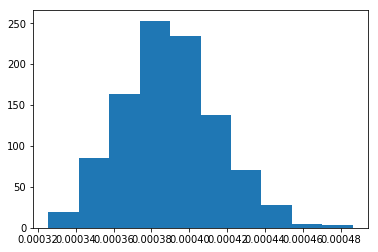

In [529]:
plt.hist(np.array(var_result)/ 1000)

In [551]:
calc_ret_var(best_weights, loan_sims, 0.99, pool_results_today_3)

3612207.3478057
0.018725114983940052
200867.66385401535
0.05560801042499291


0.33673412950455217

In [442]:
3.91295194e-03 * 30515.06280945

119.40397421945923

In [552]:
np.matmul(best_weights, portfolio_value_distribution_3)

226.78317166282352

In [425]:
loan_sims = np.array(pool_results_3).T

In [430]:
loan_sims[:,0].shape

(999,)